# F20DL Coursework Group 8 2023-24

### Group 8 Members:
- Madihah Anaum
- Tanisha Kasar
- Sneha Sunny
- Dhruv Raghu
- Moses Varghese

# Part 2: Clustering

## Content
- Data Visualization
- Running KMeans on the data
- Preprocessing the given data
    - Normalization
    - Resizing Images
    - Image Augmentation
    - Balancing the Dataset
- Testing clustering algorithms on preprocessed data
    - Kmeans
    - Spectral Clustering
        - Comparing preprocessed data with original data
    - Hierarchical Clustering
    - Mini Batch KMeans
    - Birch Clustering
    - Guassian Mixture Model
    - Affinity Propagation Clustering
- Result Comparison
- Varying the number of clusters
- Optimal number of clusters
    - Elbow Method
    - Silhouette Method
- Naive Bayes Classifier
- Analysis of Clustering Algorithms

In [1]:
# import basic libaries
import numpy as np
import pandas as pd

# libraries for data visualization
import matplotlib.pyplot as plt

import cv2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# read the coursework data set
X_train = pd.read_csv("/Users/dhruv/Documents/Y4S1/F20DL/Traffic_Sign/CompleteDataSet/x_train_all.csv")
y_train = pd.read_csv("/Users/dhruv/Documents/Y4S1/F20DL/Traffic_Sign/CompleteDataSet/y_train_all.csv")

In [4]:
# function to plot images from the dataset
def plot_images(instances, images_per_row=10, size = 48, **options):
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = 'gist_gray', **options)
    plt.axis("off")

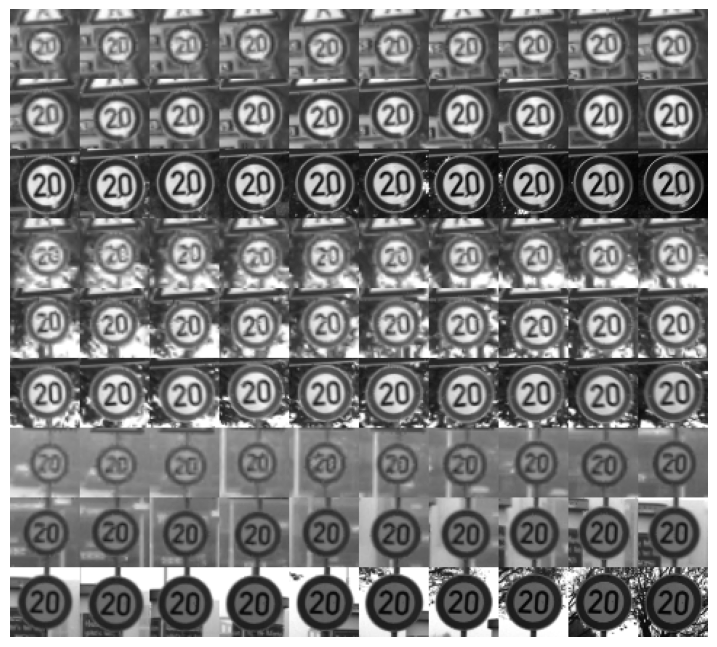

In [5]:
plt.figure(figsize=(9,9))
example_images = X_train.values[0:90]
plot_images(example_images, images_per_row=10)
plt.show()

In [6]:
class_mapping = {0: 'speed limit 20', 1: 'speed limit 30', 2: 'speed limit 50', 3: 'speed limit 60', 
                 4: 'speed limit 70', 5: 'left turn', 6: 'right turn', 7: 'beware pedestrian crossing', 
                 8: 'beware children', 9: 'beware cycle route ahead'}

# Map the class labels
target_mapped = y_train.applymap(class_mapping.get)
data = pd.concat([y_train, target_mapped], axis=1)

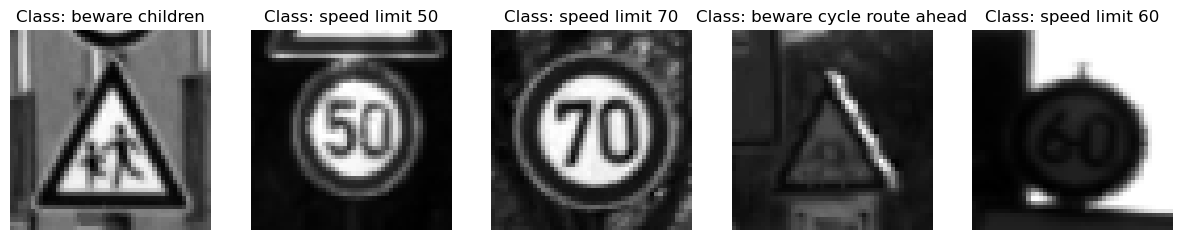

In [7]:
# Display a few samples with mapped class labels
sample_indices = np.random.choice(X_train.shape[0], 5, replace=False)

plt.figure(figsize=(15, 5))

for i, idx in enumerate(sample_indices):
    image = X_train.iloc[idx].values.reshape((48, 48))
    label_mapped = target_mapped.iloc[idx]['0']
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Class: {label_mapped}')
    plt.axis('off')

plt.show()

## Running KMeans on the data

In [8]:
from sklearn.cluster import KMeans

# Create a KMeans model with 10 clusters
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
y_pred_kmeans = kmeans.fit_predict(X_train)
centroids_kmeans = kmeans.cluster_centers_

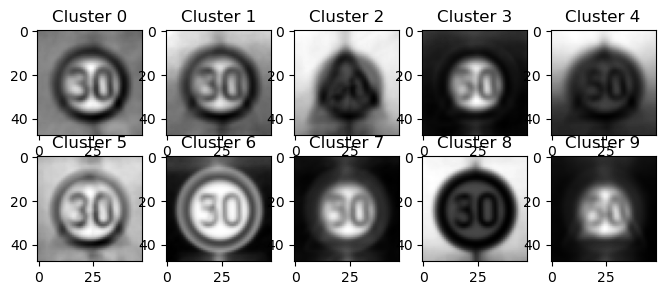

In [9]:
# visualizing centroids
cluster_centers = centroids_kmeans.reshape(-1, 48, 48)  # Reshape to 15x15 for visualization

plt.figure(figsize=(8, 3))
for i in range(num_clusters):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cluster_centers[i], cmap=plt.cm.gray)
    plt.title(f'Cluster {i}')
plt.show()

In [10]:
from sklearn.decomposition import PCA

# function to plot created clusters against actual class labels
def plot_clusters(X, y_pred, y_act):
    # perform PCA to reduce the dimensionality of the data
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # subplot to plot actual vs predicted clusters
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
    plt.title('Predicted Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    plt.subplot(1, 2, 2)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_act)
    plt.title('Actual Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

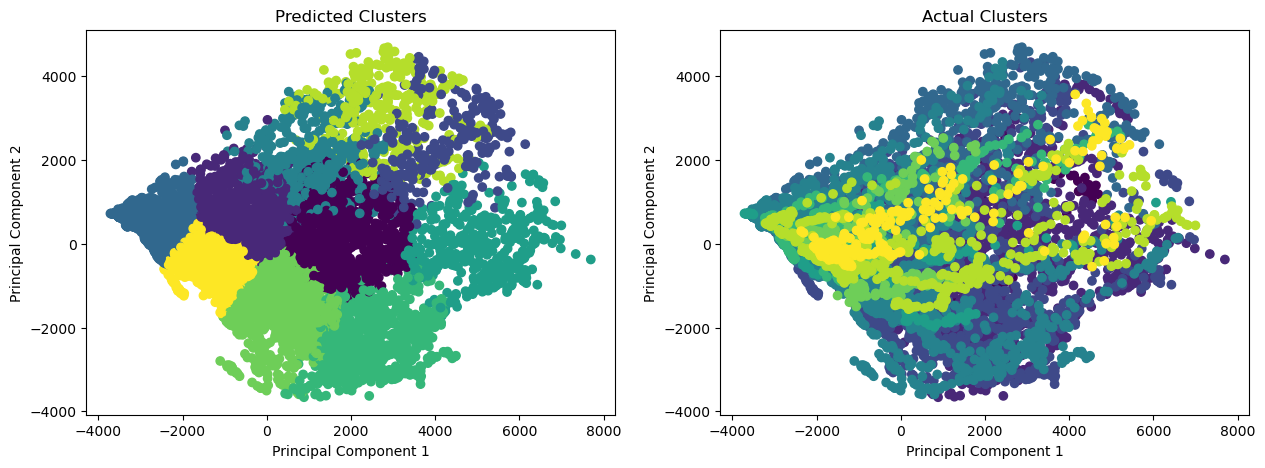

In [11]:
plot_clusters(X_train, y_pred_kmeans, y_train.values)

In [12]:
# use hungarian algorithm to match the predicted clusters to the actual clusters for accuracy calculation

from scipy.optimize import linear_sum_assignment

def match_clusters(new_y_test, y_pred):
    # Create a cost matrix for the hungarian algorithm
    cost_matrix = np.zeros((num_clusters, num_clusters))
    for i in range(num_clusters):
        for j in range(num_clusters):
            # Count the number of samples in the predicted cluster j that belong to the actual cluster i
            cost_matrix[i, j] = np.count_nonzero((y_pred == j) & (np.ravel(new_y_test) == i))
    
    # Find the optimal one-to-one mapping between predicted and actual clusters
    row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize=True)
    
    # Return the matched clusters
    return row_ind, col_ind

# find accuracy using matched clusters

def find_accuracy(y_train_rus, y_pred, row_ind, col_ind):
    # Find the matched clusters
    matched_clusters = y_pred.copy()
    for i in range(num_clusters):
        matched_clusters[y_pred == col_ind[i]] = row_ind[i]
    
    # Find the accuracy
    return np.count_nonzero(matched_clusters == np.ravel(y_train_rus)) / len(y_train_rus)

In [13]:
# function to get majority class from each cluster

def get_majority_classes(y_pred, y_train_rus, num_clusters):
    majority_classes = []

    # Iterate through each cluster
    for i in range(num_clusters):
        # Get the indices of all images in the current cluster
        cluster_indices = np.where(y_pred == i)[0]

        # Get the classes of all images in the current cluster
        cluster_classes = y_train_rus.iloc[cluster_indices]

        # Count the number of images belonging to each class
        class_counts = cluster_classes.value_counts()

        # Get the class with the highest count
        majority_class = class_counts.index[0]

        # Add the majority class to the list
        majority_classes.append(majority_class)

    # Print the majority class of each cluster
    print("\nMajority class of each cluster:")
    for i in range(num_clusters):
        print(f"Cluster {i}: {majority_classes[i]}")

    return majority_classes

In [14]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, homogeneity_completeness_v_measure

def display_metrics(X_train, y_train, y_pred):
    # metrics to evaluate the effectiveness of the clustering
    print(f'Silhouette Score: {silhouette_score(X_train, y_pred)}')
    print(f'Davies-Bouldin Score: {davies_bouldin_score(X_train, y_pred)}')

    # use techniques that compare clusters to the actual labels
    print(f'Adjusted Rand Index: {adjusted_rand_score(np.ravel(y_train), y_pred)}')
    print(f'Normalized Mutual Information: {normalized_mutual_info_score(np.ravel(y_train), y_pred)}')
    print(f'Fowlkes-Mallows Score: {fowlkes_mallows_score(np.ravel(y_train), y_pred)}')
    print(f'Homogeneity, Completeness, V-Measure: {homogeneity_completeness_v_measure(np.ravel(y_train), y_pred)}')

In [15]:
display_metrics(X_train, y_train, y_pred_kmeans)

row_ind_kmeans, col_ind_kmeans = match_clusters(y_train, y_pred_kmeans)
print(f'Hungarian Algorithm Accuracy: {find_accuracy(y_train, y_pred_kmeans, row_ind_kmeans, col_ind_kmeans)}')

# get the majority classes for each cluster
majority_classes = get_majority_classes(y_pred_kmeans, y_train, num_clusters)

Silhouette Score: 0.15491624212742874
Davies-Bouldin Score: 1.888888443569488
Adjusted Rand Index: 0.05057525794466895
Normalized Mutual Information: 0.11914806985004299
Fowlkes-Mallows Score: 0.1998063645990494
Homogeneity, Completeness, V-Measure: (0.12484240166678012, 0.11395053941593275, 0.11914806985004299)
Hungarian Algorithm Accuracy: 0.22156862745098038

Majority class of each cluster:
Cluster 0: (1,)
Cluster 1: (1,)
Cluster 2: (3,)
Cluster 3: (4,)
Cluster 4: (3,)
Cluster 5: (1,)
Cluster 6: (2,)
Cluster 7: (2,)
Cluster 8: (3,)
Cluster 9: (2,)


Insert some discussion showing how this is trash

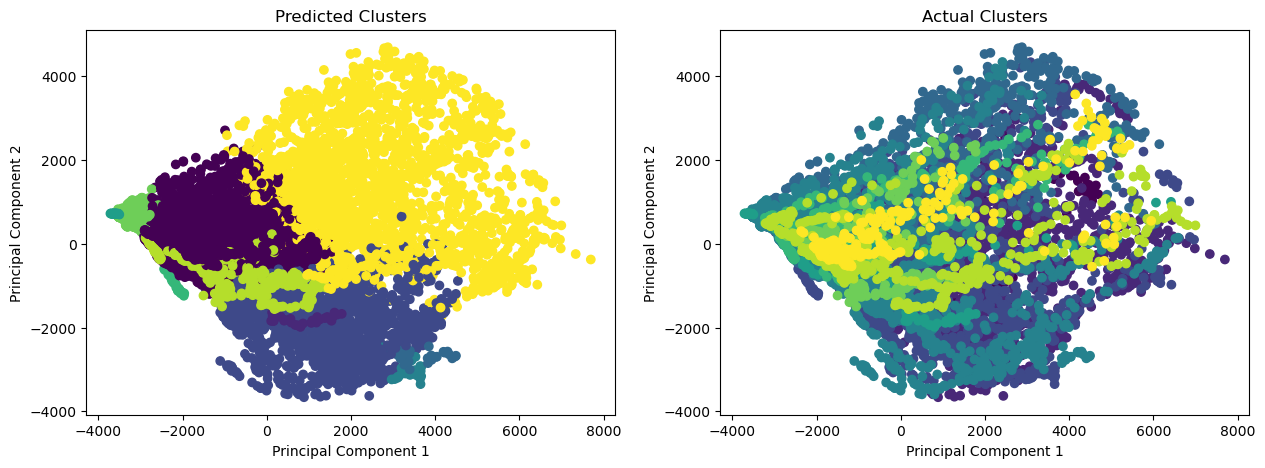

Silhouette Score: -0.06296875706939985
Davies-Bouldin Score: 1.525141414525548
Adjusted Rand Index: 0.04546605287043854
Normalized Mutual Information: 0.15222517297432372
Fowlkes-Mallows Score: 0.2603989778467718
Homogeneity, Completeness, V-Measure: (0.13334527462490736, 0.17733316532530793, 0.15222517297432375)
Hungarian Algorithm Accuracy: 0.29081527347781216

Majority class of each cluster:
Cluster 0: (2,)
Cluster 1: (5,)
Cluster 2: (2,)
Cluster 3: (4,)
Cluster 4: (2,)
Cluster 5: (5,)
Cluster 6: (2,)
Cluster 7: (4,)
Cluster 8: (8,)
Cluster 9: (1,)


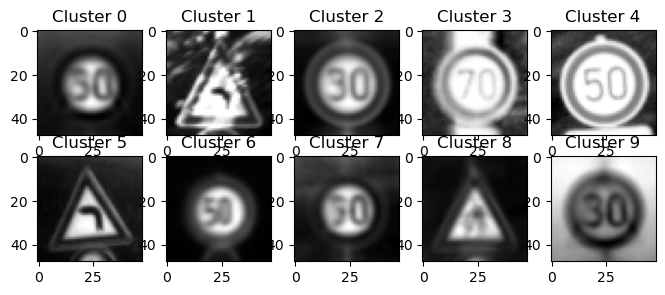

In [16]:
from sklearn.cluster import SpectralClustering

# Create an instance of the SpectralClustering class
spectral_clustering = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors')

# Predict the clusters for the test data
y_pred_spectral = spectral_clustering.fit_predict(X_train)

# Plot the clusters
plot_clusters(X_train, y_pred_spectral, y_train.values)

# Display clustering metrics
display_metrics(X_train, y_train, y_pred_spectral)

row_ind_sc, col_ind_sc = match_clusters(y_train, y_pred_spectral)
print(f'Hungarian Algorithm Accuracy: {find_accuracy(y_train, y_pred_spectral, row_ind_sc, col_ind_sc)}')

majority_classes = get_majority_classes(y_pred_spectral, y_train, num_clusters)

# Plot the centroids of each cluster
plt.figure(figsize=(8, 3))
for i in range(num_clusters):
    centroid = np.mean(X_train[y_pred_spectral == i], axis=0)
    centroid = centroid.values.reshape(48, 48)
    plt.subplot(2, 5, i + 1)
    plt.imshow(centroid, cmap=plt.cm.gray)
    plt.title(f'Cluster {i}')
plt.show()

## Preprocessing the given data

#### Normalization

In [17]:
# Change values from 0-255 to 0-1
X_train_sc = X_train/255
X_train_sc = X_train_sc.values
X_train_sc

array([[0.30588235, 0.30196078, 0.29803922, ..., 0.38431373, 0.37254902,
        0.36862745],
       [0.28627451, 0.29411765, 0.30980392, ..., 0.39215686, 0.39607843,
        0.39607843],
       [0.28235294, 0.29411765, 0.30980392, ..., 0.31372549, 0.34901961,
        0.37254902],
       ...,
       [1.        , 1.        , 1.        , ..., 0.12156863, 0.15294118,
        0.16862745],
       [1.        , 0.99215686, 1.        , ..., 0.10196078, 0.10196078,
        0.09411765],
       [0.98823529, 0.74117647, 0.93333333, ..., 0.10196078, 0.07843137,
        0.06666667]])

#### Resizing Images

In [18]:
# Apply the resize to the entire dataset
target_size = 23

X_reduced = np.apply_along_axis(
    func1d=lambda img: cv2.resize(img.reshape(48, 48), dsize=(target_size, target_size)),
    axis=1, arr=X_train_sc).reshape(-1, target_size*target_size)
X_reduced.shape

(9690, 529)

#### Image Augmentation

In [19]:
from skimage import exposure
from skimage.filters import unsharp_mask

# convert X_train_reduced to images
X_train_reduced = X_reduced.reshape(-1, target_size, target_size)

# Function to apply preprocessing
def preprocess_image(image):

    # Contrast enhancement
    p2, p98 = np.percentile(image, (2, 98))
    img_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))

    # Increase sharpness using unsharp masking
    img_sharpened = unsharp_mask(img_rescale, radius=1, amount=50)

    return img_sharpened

In [20]:
# Apply preprocessing to each image in the dataset
preprocessed_images = [preprocess_image(image) for image in X_train_reduced]

In [21]:
# Flatten augmented images
X_train_aug = np.array(preprocessed_images).reshape(-1, target_size * target_size)
X_train_aug.shape

(9690, 529)

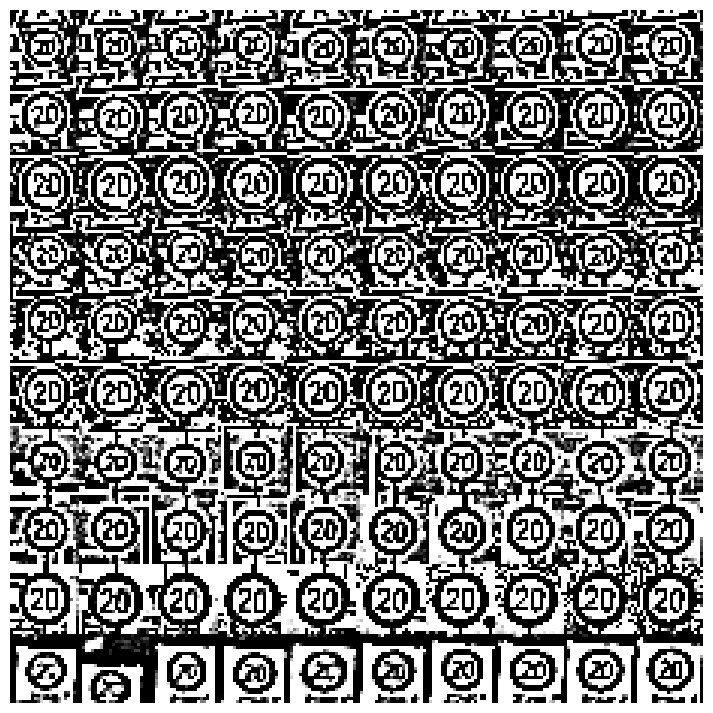

In [22]:
plt.figure(figsize=(9,9))
example_images = X_train_aug[0:100]
plot_images(example_images, images_per_row=10, size = target_size)
plt.show()

#### Balancing the Dataset
Only using undersampling technique since oversampling using SMOTE might create inaccurate images

array([[<Axes: title={'center': '0'}>]], dtype=object)

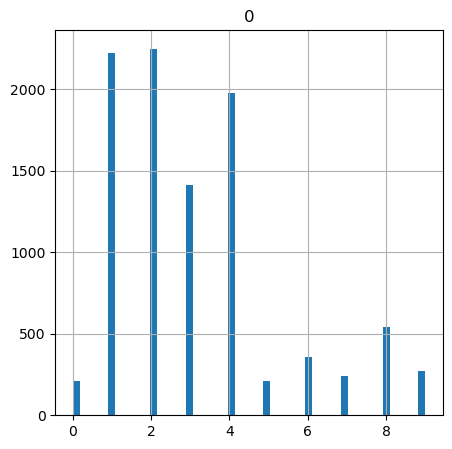

In [23]:
# initial class distribution
y_train.hist(bins=50, figsize=(5,5))

(3790, 529)
(3790, 1)


array([[<Axes: title={'center': '0'}>]], dtype=object)

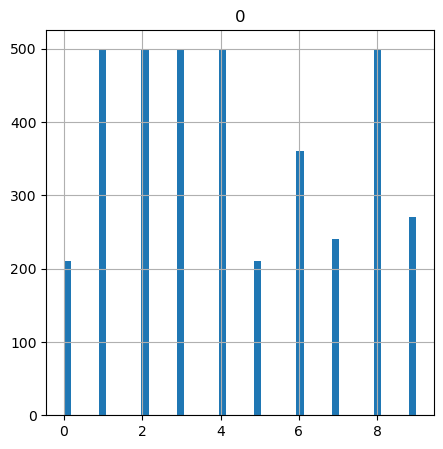

In [24]:
#undersampling
from imblearn.under_sampling import RandomUnderSampler

# Create a dictionary to specify the undersampling strategy
undersampling_strategy = {}
for class_label in range(10):  # Adjust the range according to your number of classes
    # Count samples in the class
    class_count = np.count_nonzero(y_train == class_label)
    target_count = 500

    if class_count > target_count:
        undersampling_strategy[class_label] = target_count

# Create a RandomUnderSampler instance with the specified sampling strategy
undersampler = RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=42)

# Apply Random Undersampling with the specified maximum percentage
X_train_rus, y_train_rus = undersampler.fit_resample(X_train_aug, y_train)

print(X_train_rus.shape)
print(y_train_rus.shape)

y_train_rus.hist(bins=50, figsize=(5,5))

In [25]:
print(X_train_rus.shape)
print(y_train_rus.shape)

(3790, 529)
(3790, 1)


## Testing clustering algorithms on preprocessed data

#### Kmeans

In [26]:
num_clusters = 10

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
y_pred_kmeans_pp = kmeans.fit_predict(X_train_rus)

KMeans Clustering:


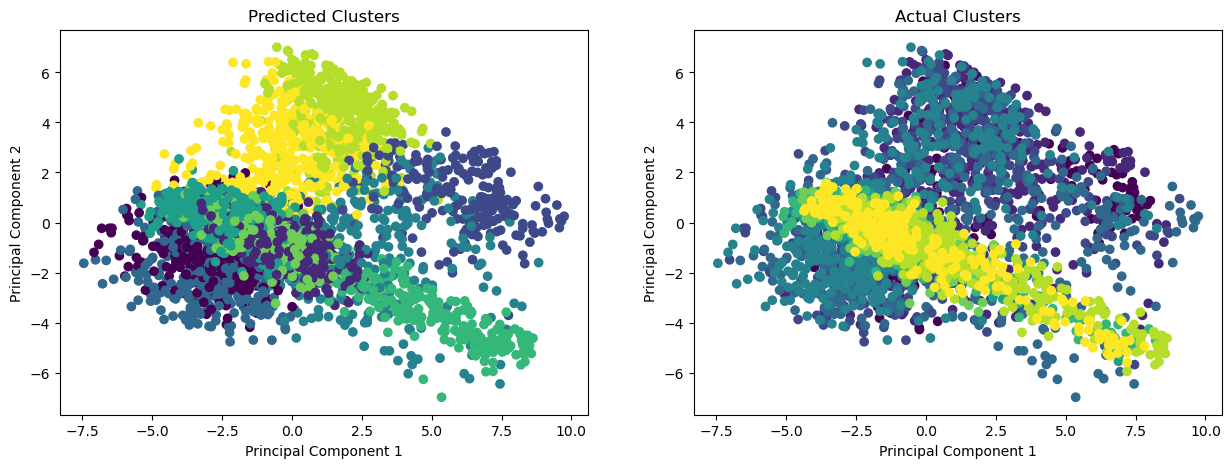

Silhouette Score: 0.04326180039938791
Davies-Bouldin Score: 3.9685698224334565
Adjusted Rand Index: 0.12599438643120192
Normalized Mutual Information: 0.28690468260607244
Fowlkes-Mallows Score: 0.2218228449920484
Homogeneity, Completeness, V-Measure: (0.28810008679104643, 0.28571915753231886, 0.2869046826060725)
Hungarian Algorithm Accuracy: 0.27941952506596307

Majority class of each cluster:
Cluster 0: (4,)
Cluster 1: (8,)
Cluster 2: (1,)
Cluster 3: (4,)
Cluster 4: (3,)
Cluster 5: (6,)
Cluster 6: (8,)
Cluster 7: (8,)
Cluster 8: (1,)
Cluster 9: (4,)


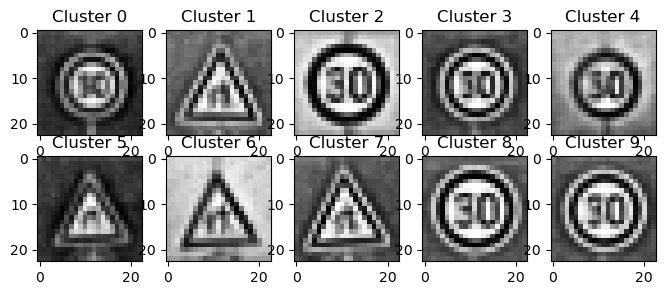

In [27]:
print('KMeans Clustering:')

plot_clusters(X_train_rus, y_pred_kmeans_pp, y_train_rus.values)

display_metrics(X_train_rus, y_train_rus, y_pred_kmeans_pp)

row_ind_kmeans_pp, col_ind_kmeans_pp = match_clusters(y_train_rus, y_pred_kmeans_pp)
print(f'Hungarian Algorithm Accuracy: {find_accuracy(y_train_rus, y_pred_kmeans_pp, row_ind_kmeans_pp, col_ind_kmeans_pp)}')

majority_classes = get_majority_classes(y_pred_kmeans_pp, y_train_rus, num_clusters)

cluster_centers = kmeans.cluster_centers_
cluster_centers = cluster_centers.reshape(-1, target_size, target_size)  # Reshape to 15x15 for visualization
plt.figure(figsize=(8, 3))
for i in range(num_clusters):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cluster_centers[i], cmap=plt.cm.gray)
    plt.title(f'Cluster {i}')
plt.show()

#### Spectral Clustering

In [28]:
spectral_clustering = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors')
y_pred_spectral_pp = spectral_clustering.fit_predict(X_train_rus)

Spectral Clustering


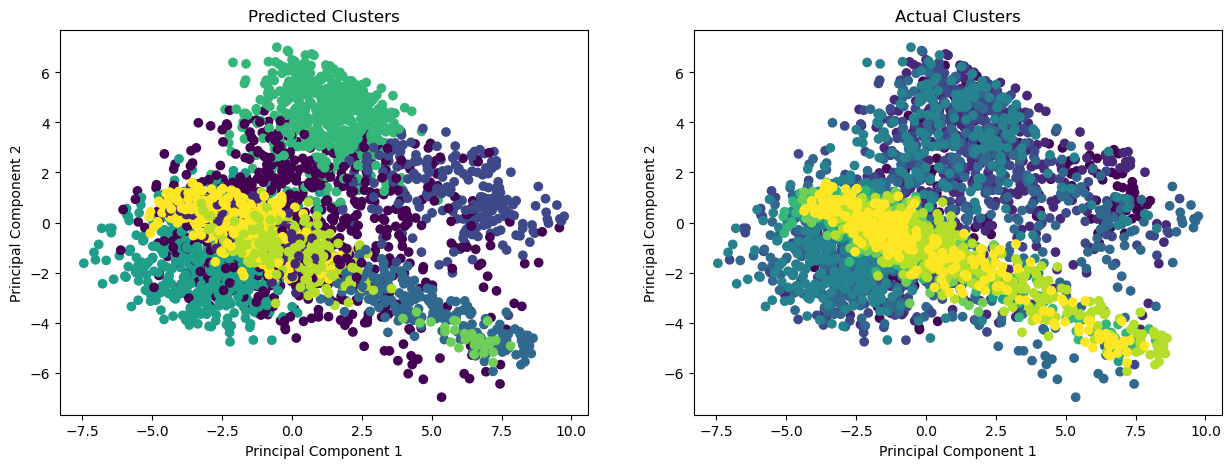

Silhouette Score: 0.03174910624972987
Davies-Bouldin Score: 3.8023553320983545
Adjusted Rand Index: 0.16207725270240828
Normalized Mutual Information: 0.3506326030068159
Fowlkes-Mallows Score: 0.26988200409814694
Homogeneity, Completeness, V-Measure: (0.33464452692119984, 0.3682250312167915, 0.350632603006816)
Hungarian Algorithm Accuracy: 0.31029023746701845

Majority class of each cluster:
Cluster 0: (3,)
Cluster 1: (8,)
Cluster 2: (1,)
Cluster 3: (8,)
Cluster 4: (5,)
Cluster 5: (4,)
Cluster 6: (1,)
Cluster 7: (9,)
Cluster 8: (8,)
Cluster 9: (6,)


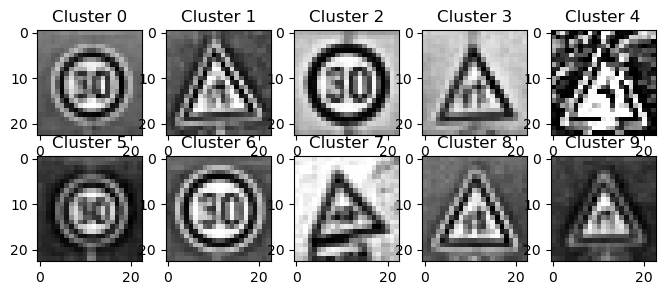

In [29]:
print('Spectral Clustering')

plot_clusters(X_train_rus, y_pred_spectral_pp, y_train_rus.values)

display_metrics(X_train_rus, y_train_rus, y_pred_spectral_pp)

row_ind_sc_pp, col_ind_sc_pp = match_clusters(y_train_rus, y_pred_spectral_pp)
print(f'Hungarian Algorithm Accuracy: {find_accuracy(y_train_rus, y_pred_spectral_pp, row_ind_sc_pp, col_ind_sc_pp)}')

majority_classes = get_majority_classes(y_pred_spectral_pp, y_train_rus, num_clusters)

# Plot the centroids of each cluster
plt.figure(figsize=(8, 3))
for i in range(num_clusters):
    centroid = np.mean(X_train_rus[y_pred_spectral_pp == i], axis=0)
    centroid = centroid.reshape(target_size, target_size)
    plt.subplot(2, 5, i + 1)
    plt.imshow(centroid, cmap=plt.cm.gray)
    plt.title(f'Cluster {i}')

##### Comparing preprocessed data with original data

In [30]:
# Create a dictionary to store the results of the clustering algorithms
results_pp = {'Algorithm': ['KMeans', 'KMeans-PreProcess', 'Spectral', 'Spectral-PreProcess'],
           'Silhouette Score': [silhouette_score(X_train, y_pred_kmeans), silhouette_score(X_train_rus, y_pred_kmeans_pp), silhouette_score(X_train, y_pred_spectral), silhouette_score(X_train_rus, y_pred_spectral_pp)],
           'Davies-Bouldin Score': [davies_bouldin_score(X_train, y_pred_kmeans), davies_bouldin_score(X_train_rus, y_pred_kmeans_pp), davies_bouldin_score(X_train, y_pred_spectral), davies_bouldin_score(X_train_rus, y_pred_spectral_pp)],
           'Adjusted Rand Index': [adjusted_rand_score(np.ravel(y_train), y_pred_kmeans), adjusted_rand_score(np.ravel(y_train_rus), y_pred_kmeans_pp), adjusted_rand_score(np.ravel(y_train), y_pred_spectral), adjusted_rand_score(np.ravel(y_train_rus), y_pred_spectral_pp)],
           'Normalized Mutual Information': [normalized_mutual_info_score(np.ravel(y_train), y_pred_kmeans), normalized_mutual_info_score(np.ravel(y_train_rus), y_pred_kmeans_pp), normalized_mutual_info_score(np.ravel(y_train), y_pred_spectral), normalized_mutual_info_score(np.ravel(y_train_rus), y_pred_spectral_pp)],
           'Fowlkes-Mallows Score': [fowlkes_mallows_score(np.ravel(y_train), y_pred_kmeans), fowlkes_mallows_score(np.ravel(y_train_rus), y_pred_kmeans_pp), fowlkes_mallows_score(np.ravel(y_train), y_pred_spectral), fowlkes_mallows_score(np.ravel(y_train_rus), y_pred_spectral_pp)],
           'Hungarian Algorithm Accuracy': [find_accuracy(y_train, y_pred_kmeans, row_ind_kmeans, col_ind_kmeans), find_accuracy(y_train_rus, y_pred_kmeans_pp, row_ind_kmeans_pp, col_ind_kmeans_pp), find_accuracy(y_train, y_pred_spectral, row_ind_sc, col_ind_sc), find_accuracy(y_train_rus, y_pred_spectral_pp, row_ind_sc_pp, col_ind_sc_pp)]}

# Create a pandas dataframe from the dictionary
df_results_pp = pd.DataFrame(results_pp)

# Display the dataframe
print("Clustering Comparison before and after Preprocessing:")
print(df_results_pp.to_string(index=False))

Clustering Comparison before and after Preprocessing:
          Algorithm  Silhouette Score  Davies-Bouldin Score  Adjusted Rand Index  Normalized Mutual Information  Fowlkes-Mallows Score  Hungarian Algorithm Accuracy
             KMeans          0.154916              1.888888             0.050575                       0.119148               0.199806                      0.221569
  KMeans-PreProcess          0.043262              3.968570             0.125994                       0.286905               0.221823                      0.279420
           Spectral         -0.062969              1.525141             0.045466                       0.152225               0.260399                      0.290815
Spectral-PreProcess          0.031749              3.802355             0.162077                       0.350633               0.269882                      0.310290


#### Hierarchial Clustering (Agglomerative)

Silhouette Score: 0.027703441641669938
Davies-Bouldin Score: 4.260975146456237
Adjusted Rand Index: 0.1406843172428167
Normalized Mutual Information: 0.3157216022834283
Fowlkes-Mallows Score: 0.24512169468878706
Homogeneity, Completeness, V-Measure: (0.309635305969755, 0.32205196464007635, 0.3157216022834283)
Hungarian Algorithm Accuracy: 0.2725593667546174

Majority class of each cluster:
Cluster 0: (8,)
Cluster 1: (2,)
Cluster 2: (4,)
Cluster 3: (1,)
Cluster 4: (1,)
Cluster 5: (8,)
Cluster 6: (3,)
Cluster 7: (0,)
Cluster 8: (4,)
Cluster 9: (6,)


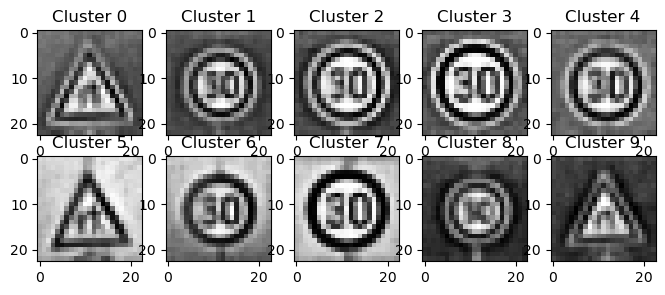

In [31]:
from sklearn.cluster import AgglomerativeClustering

# Create an instance of the AgglomerativeClustering class
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters)

# Predict the clusters for the test data
y_pred_agg = agg_clustering.fit_predict(X_train_rus)

display_metrics(X_train_rus, y_train_rus, y_pred_agg)

row_ind_gg, col_ind_agg = match_clusters(y_train_rus, y_pred_agg)
print(f'Hungarian Algorithm Accuracy: {find_accuracy(y_train_rus, y_pred_agg, row_ind_gg, col_ind_agg)}')

majority_classes = get_majority_classes(y_pred_agg, y_train_rus, num_clusters)

# Plot the centroids of each cluster
plt.figure(figsize=(8, 3))
for i in range(num_clusters):
    centroid = np.mean(X_train_rus[y_pred_agg == i], axis=0)
    centroid = centroid.reshape(target_size, target_size)
    plt.subplot(2, 5, i + 1)
    plt.imshow(centroid, cmap=plt.cm.gray)
    plt.title(f'Cluster {i}')

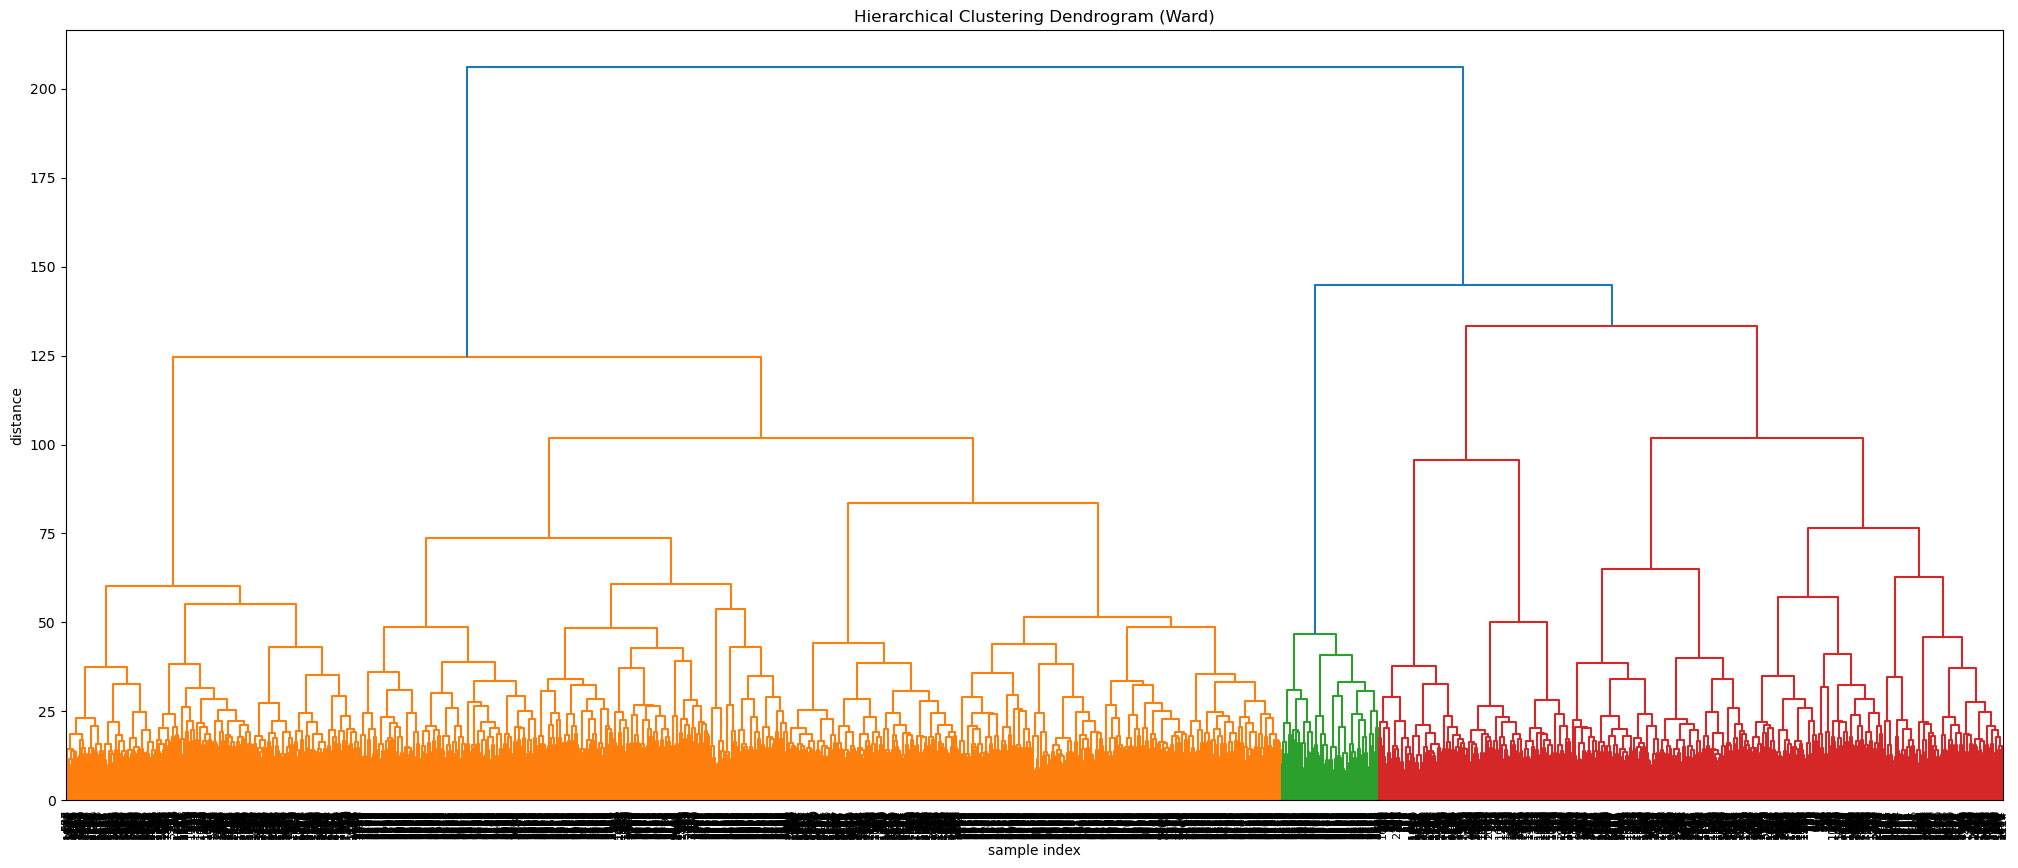

In [32]:
# hierarchical clustering dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X_train_rus, method='ward', metric='euclidean')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
plt.show()

#### Mini Batch KMeans

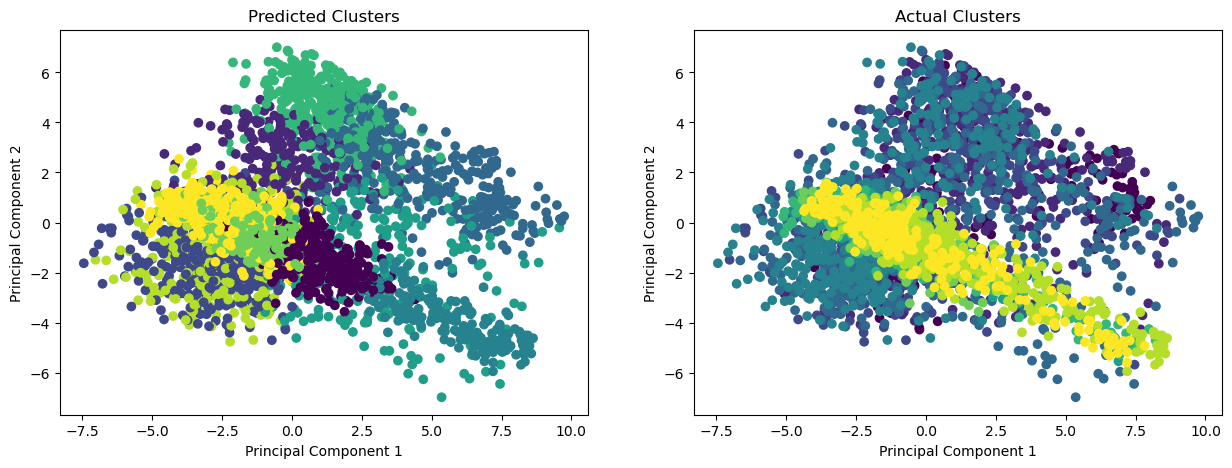

Silhouette Score: 0.03849285582693103
Davies-Bouldin Score: 4.157883314129245
Adjusted Rand Index: 0.12894352547126048
Normalized Mutual Information: 0.29383802558816324
Fowlkes-Mallows Score: 0.22649627950750853
Homogeneity, Completeness, V-Measure: (0.2936807368333479, 0.29399548291385474, 0.2938380255881633)
Hungarian Algorithm Accuracy: 0.27862796833773085

Majority class of each cluster:
Cluster 0: (8,)
Cluster 1: (4,)
Cluster 2: (4,)
Cluster 3: (1,)
Cluster 4: (8,)
Cluster 5: (3,)
Cluster 6: (1,)
Cluster 7: (8,)
Cluster 8: (4,)
Cluster 9: (6,)


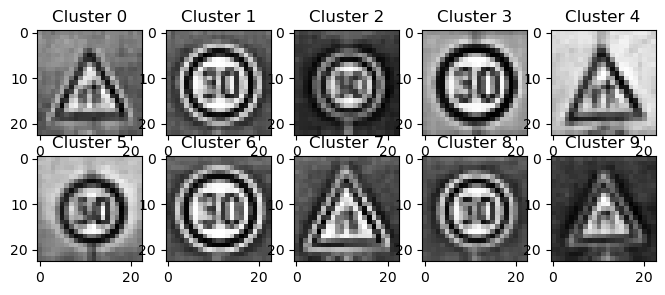

In [33]:
# Mini Batch KMeans Clustering
from sklearn.cluster import MiniBatchKMeans

# Create an instance of the MiniBatchKMeans class
mbk_clustering = MiniBatchKMeans(n_clusters=num_clusters, random_state=42)

# Predict the clusters for the test data
y_pred_mbk = mbk_clustering.fit_predict(X_train_rus)

# Plot the clusters
plot_clusters(X_train_rus, y_pred_mbk, y_train_rus.values)

display_metrics(X_train_rus, y_train_rus, y_pred_mbk)

row_ind_mbk, col_ind_mbk = match_clusters(y_train_rus, y_pred_mbk)
print(f'Hungarian Algorithm Accuracy: {find_accuracy(y_train_rus, y_pred_mbk, row_ind_mbk, col_ind_mbk)}')

majority_classes = get_majority_classes(y_pred_mbk, y_train_rus, num_clusters)

# Plot the centroids of each cluster
plt.figure(figsize=(8, 3))
for i in range(num_clusters):
    centroid = np.mean(X_train_rus[y_pred_mbk == i], axis=0)
    centroid = centroid.reshape(target_size, target_size)
    plt.subplot(2, 5, i + 1)
    plt.imshow(centroid, cmap=plt.cm.gray)
    plt.title(f'Cluster {i}')

#### Birch Clustering

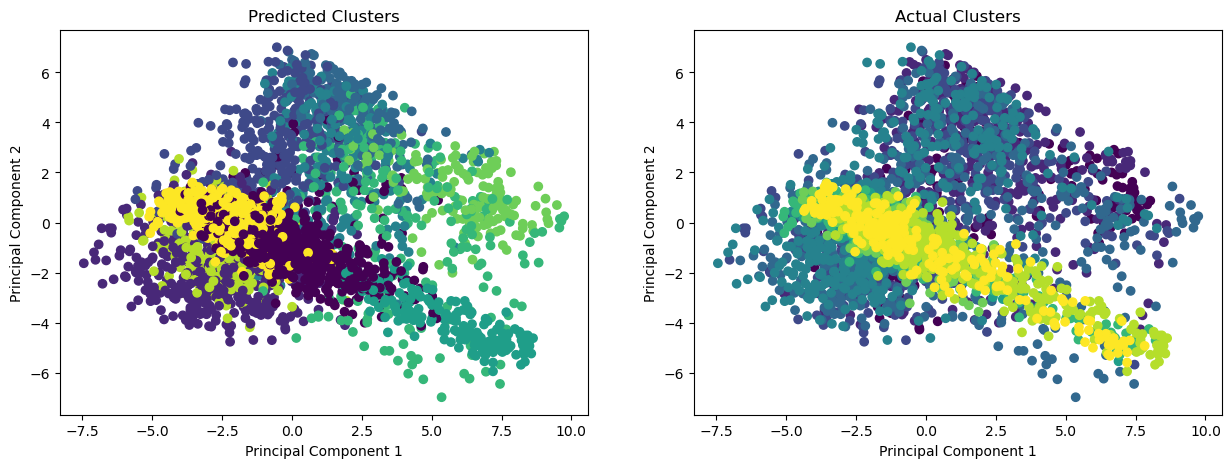

Silhouette Score: 0.027703441641669938
Davies-Bouldin Score: 4.260975146456237
Adjusted Rand Index: 0.1406843172428167
Normalized Mutual Information: 0.3157216022834283
Fowlkes-Mallows Score: 0.24512169468878706
Homogeneity, Completeness, V-Measure: (0.309635305969755, 0.32205196464007635, 0.3157216022834283)
Hungarian Algorithm Accuracy: 0.2725593667546174

Majority class of each cluster:
Cluster 0: (8,)
Cluster 1: (2,)
Cluster 2: (4,)
Cluster 3: (1,)
Cluster 4: (1,)
Cluster 5: (8,)
Cluster 6: (3,)
Cluster 7: (0,)
Cluster 8: (4,)
Cluster 9: (6,)


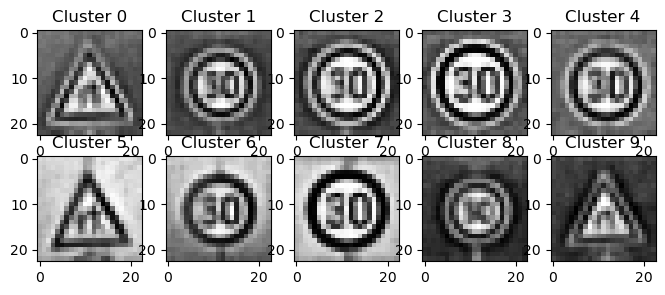

In [34]:
# Birch Clustering
from sklearn.cluster import Birch

# Create an instance of the Birch class
birch_clustering = Birch(n_clusters=num_clusters)

# Predict the clusters for the test data
y_pred_birch = birch_clustering.fit_predict(X_train_rus)

# Plot the clusters
plot_clusters(X_train_rus, y_pred_birch, y_train_rus.values)

display_metrics(X_train_rus, y_train_rus, y_pred_birch)

row_ind_birch, col_ind_birch = match_clusters(y_train_rus, y_pred_birch)
print(f'Hungarian Algorithm Accuracy: {find_accuracy(y_train_rus, y_pred_birch, row_ind_birch, col_ind_birch)}')

majority_classes = get_majority_classes(y_pred_birch, y_train_rus, num_clusters)

# Plot the centroids of each cluster
plt.figure(figsize=(8, 3))
for i in range(num_clusters):
    centroid = np.mean(X_train_rus[y_pred_birch == i], axis=0)
    centroid = centroid.reshape(target_size, target_size)
    plt.subplot(2, 5, i + 1)
    plt.imshow(centroid, cmap=plt.cm.gray)
    plt.title(f'Cluster {i}')

#### Guassian Mixture Model

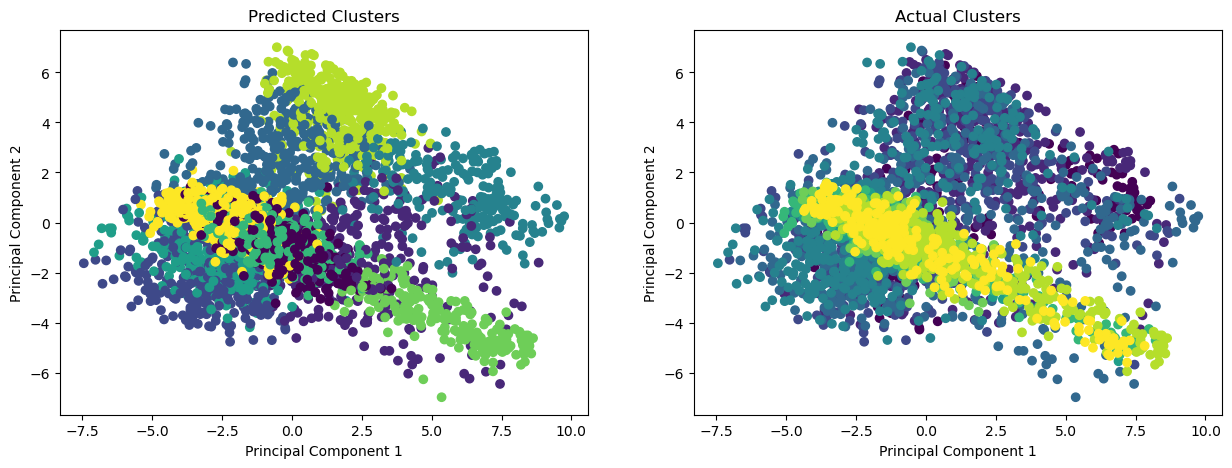

Silhouette Score: 0.04375593390129525
Davies-Bouldin Score: 4.000280376590403
Adjusted Rand Index: 0.1266227259918061
Normalized Mutual Information: 0.28732101643635904
Fowlkes-Mallows Score: 0.22167062148538932
Homogeneity, Completeness, V-Measure: (0.288913439212866, 0.2857460515540355, 0.28732101643635904)
Hungarian Algorithm Accuracy: 0.2728232189973615

Majority class of each cluster:
Cluster 0: (8,)
Cluster 1: (3,)
Cluster 2: (4,)
Cluster 3: (4,)
Cluster 4: (1,)
Cluster 5: (4,)
Cluster 6: (8,)
Cluster 7: (8,)
Cluster 8: (1,)
Cluster 9: (6,)


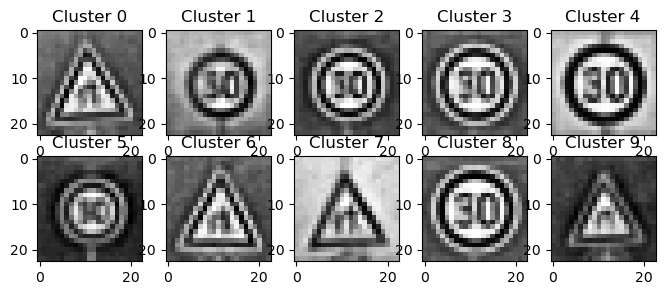

In [35]:
# Guassin Mixture Model Clustering
from sklearn.mixture import GaussianMixture

# Create an instance of the GaussianMixture class
gmm_clustering = GaussianMixture(n_components=num_clusters)

# Predict the clusters for the test data
y_pred_gmm = gmm_clustering.fit_predict(X_train_rus)

# Plot the clusters
plot_clusters(X_train_rus, y_pred_gmm, y_train_rus.values)

display_metrics(X_train_rus, y_train_rus, y_pred_gmm)

row_ind_gmm, col_ind_gmm = match_clusters(y_train_rus, y_pred_gmm)
print(f'Hungarian Algorithm Accuracy: {find_accuracy(y_train_rus, y_pred_gmm, row_ind_gmm, col_ind_gmm)}')

majority_classes = get_majority_classes(y_pred_gmm, y_train_rus, num_clusters)

# Plot the centroids of each cluster
plt.figure(figsize=(8, 3))
for i in range(num_clusters):
    centroid = np.mean(X_train_rus[y_pred_gmm == i], axis=0)
    centroid = centroid.reshape(target_size, target_size)
    plt.subplot(2, 5, i + 1)
    plt.imshow(centroid, cmap=plt.cm.gray)
    plt.title(f'Cluster {i}')

#### Affinity Propagation Clustering

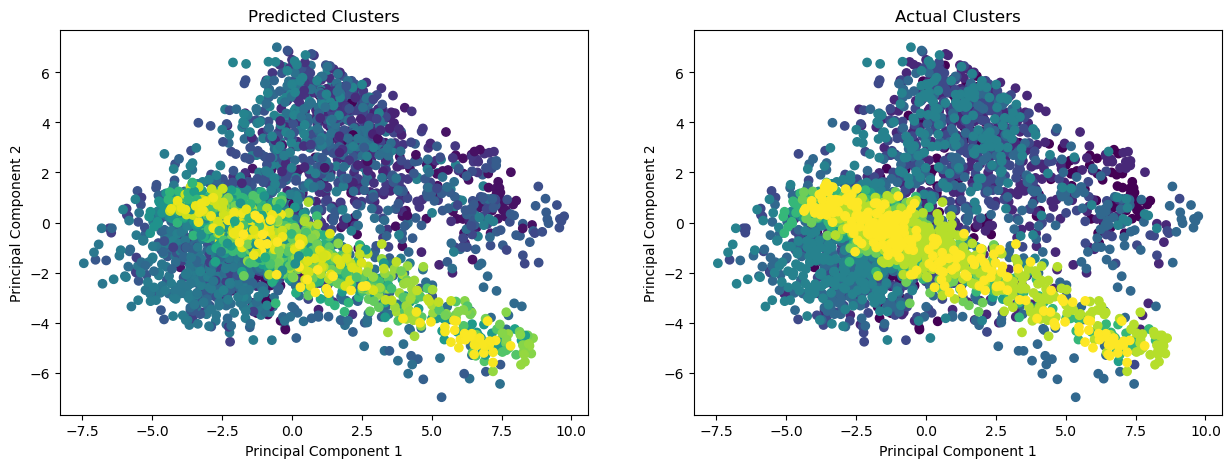

Silhouette Score: 0.030188214234140403
Davies-Bouldin Score: 2.838879830888278
Adjusted Rand Index: 0.030276139612700134
Normalized Mutual Information: 0.3672354928159381
Fowlkes-Mallows Score: 0.0939868305456868
Homogeneity, Completeness, V-Measure: (0.6207501443048394, 0.260746499522936, 0.36723549281593804)
Hungarian Algorithm Accuracy: 0.00395778364116095

Majority class of each cluster:
Cluster 0: (0,)
Cluster 1: (0,)
Cluster 2: (0,)
Cluster 3: (0,)
Cluster 4: (0,)
Cluster 5: (0,)
Cluster 6: (0,)
Cluster 7: (0,)
Cluster 8: (0,)
Cluster 9: (0,)


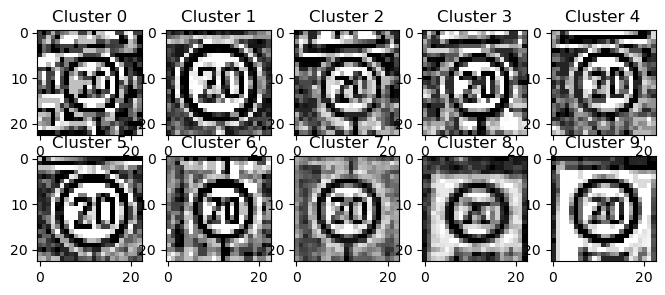

In [36]:
# Affinity Propagation Clustering
from sklearn.cluster import AffinityPropagation

# Create an instance of the AffinityPropagation class
aff_clustering = AffinityPropagation()

# Predict the clusters for the test data
y_pred_aff = aff_clustering.fit_predict(X_train_rus)

# Plot the clusters
plot_clusters(X_train_rus, y_pred_aff, y_train_rus.values)

display_metrics(X_train_rus, y_train_rus, y_pred_aff)

row_ind_aff, col_ind_aff = match_clusters(y_train_rus, y_pred_aff)
print(f'Hungarian Algorithm Accuracy: {find_accuracy(y_train_rus, y_pred_aff, row_ind_aff, col_ind_aff)}')

majority_classes = get_majority_classes(y_pred_aff, y_train_rus, num_clusters)

# Plot the centroids of each cluster
plt.figure(figsize=(8, 3))
for i in range(num_clusters):
    centroid = np.mean(X_train_rus[y_pred_aff == i], axis=0)
    centroid = centroid.reshape(target_size, target_size)
    plt.subplot(2, 5, i + 1)
    plt.imshow(centroid, cmap=plt.cm.gray)
    plt.title(f'Cluster {i}')

## Result Comparison

In [37]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

# Create a dictionary to store the results of the clustering algorithms
results = {'Algorithm': ['KMeans', 'Spectral', 'Agglomerative', 'MiniBatchKMeans', 'Birch', 'GaussianMixture', 'AffinityPropagation'],
           'Silhouette Score': [silhouette_score(X_train_rus, y_pred_kmeans_pp), silhouette_score(X_train_rus, y_pred_spectral_pp), silhouette_score(X_train_rus, y_pred_agg), silhouette_score(X_train_rus, y_pred_mbk), silhouette_score(X_train_rus, y_pred_birch), silhouette_score(X_train_rus, y_pred_gmm), silhouette_score(X_train_rus, y_pred_aff)],
           'Davies-Bouldin Score': [davies_bouldin_score(X_train_rus, y_pred_kmeans_pp), davies_bouldin_score(X_train_rus, y_pred_spectral_pp), davies_bouldin_score(X_train_rus, y_pred_agg), davies_bouldin_score(X_train_rus, y_pred_mbk), davies_bouldin_score(X_train_rus, y_pred_birch), davies_bouldin_score(X_train_rus, y_pred_gmm), davies_bouldin_score(X_train_rus, y_pred_aff)],
           'Adjusted Rand Index': [adjusted_rand_score(np.ravel(y_train_rus), y_pred_kmeans_pp), adjusted_rand_score(np.ravel(y_train_rus), y_pred_spectral_pp), adjusted_rand_score(np.ravel(y_train_rus), y_pred_agg), adjusted_rand_score(np.ravel(y_train_rus), y_pred_mbk), adjusted_rand_score(np.ravel(y_train_rus), y_pred_birch), adjusted_rand_score(np.ravel(y_train_rus), y_pred_gmm), adjusted_rand_score(np.ravel(y_train_rus), y_pred_aff)],
           'Normalized Mutual Information': [normalized_mutual_info_score(np.ravel(y_train_rus), y_pred_kmeans_pp), normalized_mutual_info_score(np.ravel(y_train_rus), y_pred_spectral_pp), normalized_mutual_info_score(np.ravel(y_train_rus), y_pred_agg), normalized_mutual_info_score(np.ravel(y_train_rus), y_pred_mbk), normalized_mutual_info_score(np.ravel(y_train_rus), y_pred_birch), normalized_mutual_info_score(np.ravel(y_train_rus), y_pred_gmm), normalized_mutual_info_score(np.ravel(y_train_rus), y_pred_aff)],
           'Fowlkes-Mallows Score': [fowlkes_mallows_score(np.ravel(y_train_rus), y_pred_kmeans_pp), fowlkes_mallows_score(np.ravel(y_train_rus), y_pred_spectral_pp), fowlkes_mallows_score(np.ravel(y_train_rus), y_pred_agg), fowlkes_mallows_score(np.ravel(y_train_rus), y_pred_mbk), fowlkes_mallows_score(np.ravel(y_train_rus), y_pred_birch), fowlkes_mallows_score(np.ravel(y_train_rus), y_pred_gmm), fowlkes_mallows_score(np.ravel(y_train_rus), y_pred_aff)],
           'Homogeneity Score': [homogeneity_score(np.ravel(y_train_rus), y_pred_kmeans_pp), homogeneity_score(np.ravel(y_train_rus), y_pred_spectral_pp), homogeneity_score(np.ravel(y_train_rus), y_pred_agg), homogeneity_score(np.ravel(y_train_rus), y_pred_mbk), homogeneity_score(np.ravel(y_train_rus), y_pred_birch), homogeneity_score(np.ravel(y_train_rus), y_pred_gmm), homogeneity_score(np.ravel(y_train_rus), y_pred_aff)],
           'Completeness Score': [completeness_score(np.ravel(y_train_rus), y_pred_kmeans_pp), completeness_score(np.ravel(y_train_rus), y_pred_spectral_pp), completeness_score(np.ravel(y_train_rus), y_pred_agg), completeness_score(np.ravel(y_train_rus), y_pred_mbk), completeness_score(np.ravel(y_train_rus), y_pred_birch), completeness_score(np.ravel(y_train_rus), y_pred_gmm), completeness_score(np.ravel(y_train_rus), y_pred_aff)],
           'V-Measure Score': [v_measure_score(np.ravel(y_train_rus), y_pred_kmeans_pp), v_measure_score(np.ravel(y_train_rus), y_pred_spectral_pp), v_measure_score(np.ravel(y_train_rus), y_pred_agg), v_measure_score(np.ravel(y_train_rus), y_pred_mbk), v_measure_score(np.ravel(y_train_rus), y_pred_birch), v_measure_score(np.ravel(y_train_rus), y_pred_gmm), v_measure_score(np.ravel(y_train_rus), y_pred_aff)],
           'Hungarian Algorithm Accuracy': [find_accuracy(y_train_rus, y_pred_kmeans_pp, row_ind_kmeans_pp, col_ind_kmeans_pp), find_accuracy(y_train_rus, y_pred_spectral_pp, row_ind_sc_pp, col_ind_sc_pp), find_accuracy(y_train_rus, y_pred_agg, row_ind_gg, col_ind_agg), find_accuracy(y_train_rus, y_pred_mbk, row_ind_mbk, col_ind_mbk), find_accuracy(y_train_rus, y_pred_birch, row_ind_birch, col_ind_birch), find_accuracy(y_train_rus, y_pred_gmm, row_ind_gmm, col_ind_gmm), find_accuracy(y_train_rus, y_pred_aff, row_ind_aff, col_ind_aff)]}

# Create a pandas dataframe from the dictionary
df_results = pd.DataFrame(results)

# Display the dataframe
print("Clustering Comparison:")
print(df_results.to_string(index=False))


Clustering Comparison:
          Algorithm  Silhouette Score  Davies-Bouldin Score  Adjusted Rand Index  Normalized Mutual Information  Fowlkes-Mallows Score  Homogeneity Score  Completeness Score  V-Measure Score  Hungarian Algorithm Accuracy
             KMeans          0.043262              3.968570             0.125994                       0.286905               0.221823           0.288100            0.285719         0.286905                      0.279420
           Spectral          0.031749              3.802355             0.162077                       0.350633               0.269882           0.334645            0.368225         0.350633                      0.310290
      Agglomerative          0.027703              4.260975             0.140684                       0.315722               0.245122           0.309635            0.322052         0.315722                      0.272559
    MiniBatchKMeans          0.038493              4.157883             0.128944             

## Varying the number of clusters


 Num Clusters  2 :


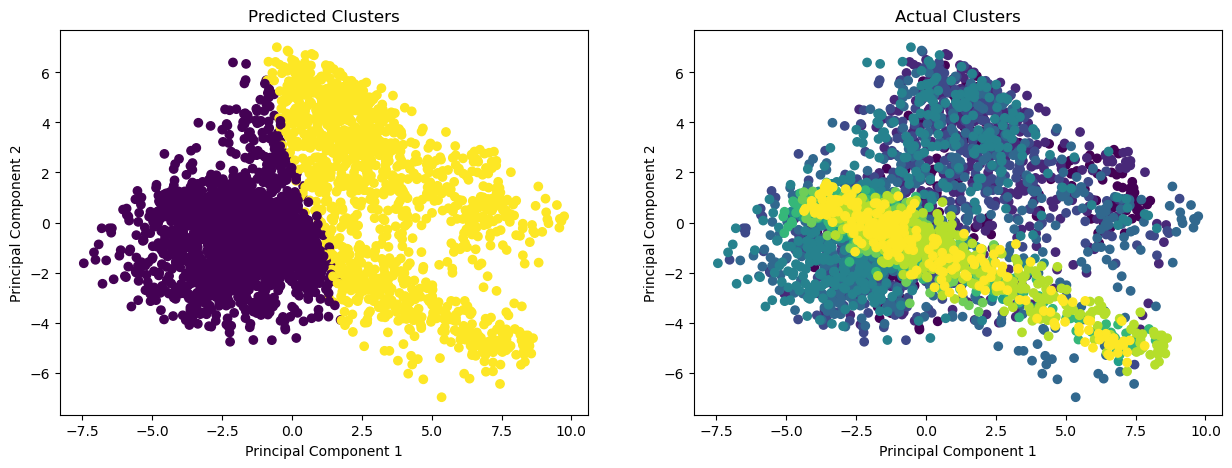

Silhouette Score: 0.06570397282357511
Davies-Bouldin Score: 3.8537202707615537
Adjusted Rand Index: 0.013210407822125366
Normalized Mutual Information: 0.046782055570749964
Fowlkes-Mallows Score: 0.26072578588069456
Homogeneity, Completeness, V-Measure: (0.030124154918771077, 0.10465195900147917, 0.04678205557074997)
Hungarian Algorithm Accuracy: 0.17519788918205806



 Num Clusters  3 :


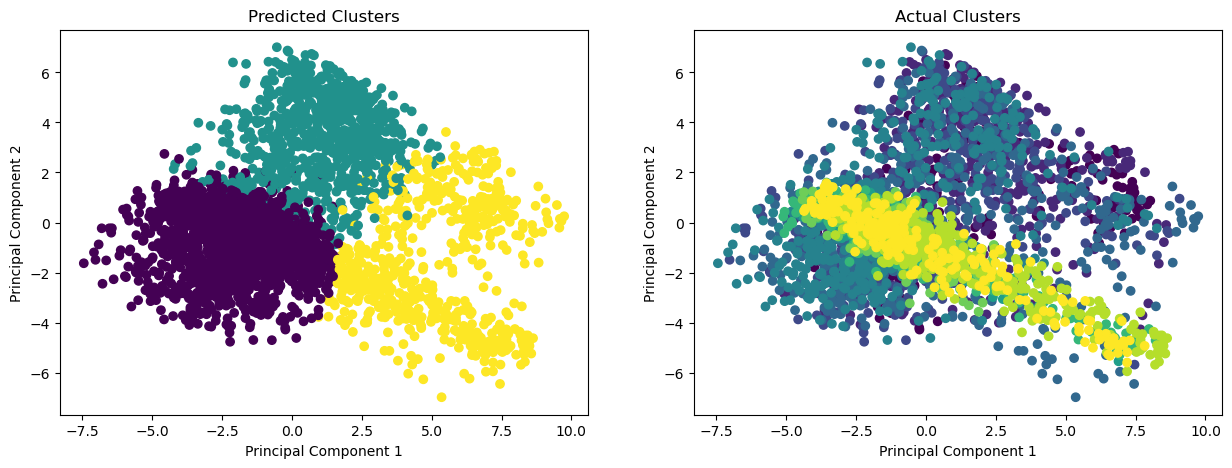

Silhouette Score: 0.058270106669363615
Davies-Bouldin Score: 3.505671234031993
Adjusted Rand Index: 0.02684966775797778
Normalized Mutual Information: 0.11627684692882075
Fowlkes-Mallows Score: 0.2500124720652538
Homogeneity, Completeness, V-Measure: (0.08252886667663546, 0.19672041861376155, 0.11627684692882075)
Hungarian Algorithm Accuracy: 0.19604221635883906



 Num Clusters  4 :


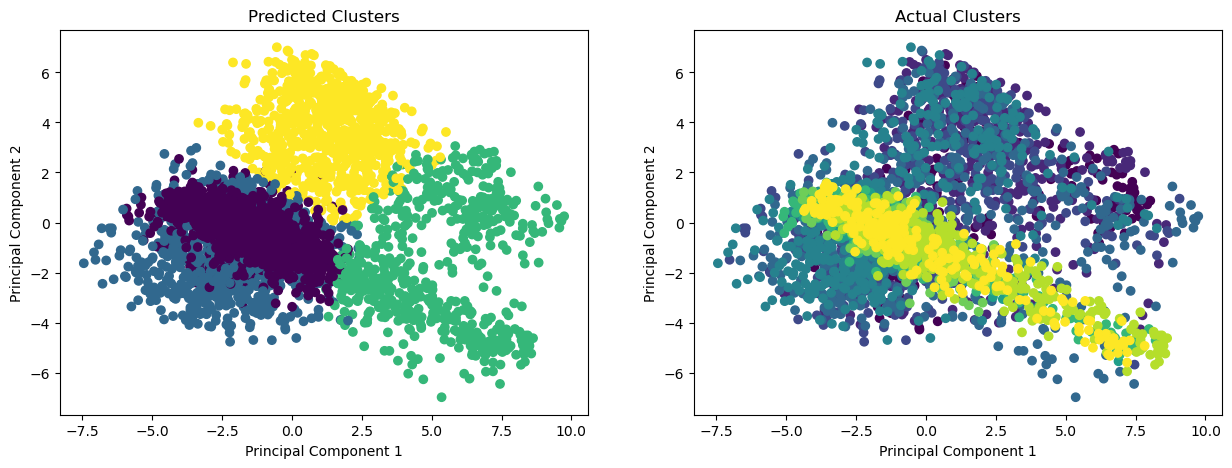

Silhouette Score: 0.05119743157831637
Davies-Bouldin Score: 3.932768718355929
Adjusted Rand Index: 0.09809590585885256
Normalized Mutual Information: 0.22187859673675772
Fowlkes-Mallows Score: 0.27210352726154974
Homogeneity, Completeness, V-Measure: (0.1757598439758585, 0.30081008404482684, 0.22187859673675775)
Hungarian Algorithm Accuracy: 0.2532981530343008



 Num Clusters  5 :


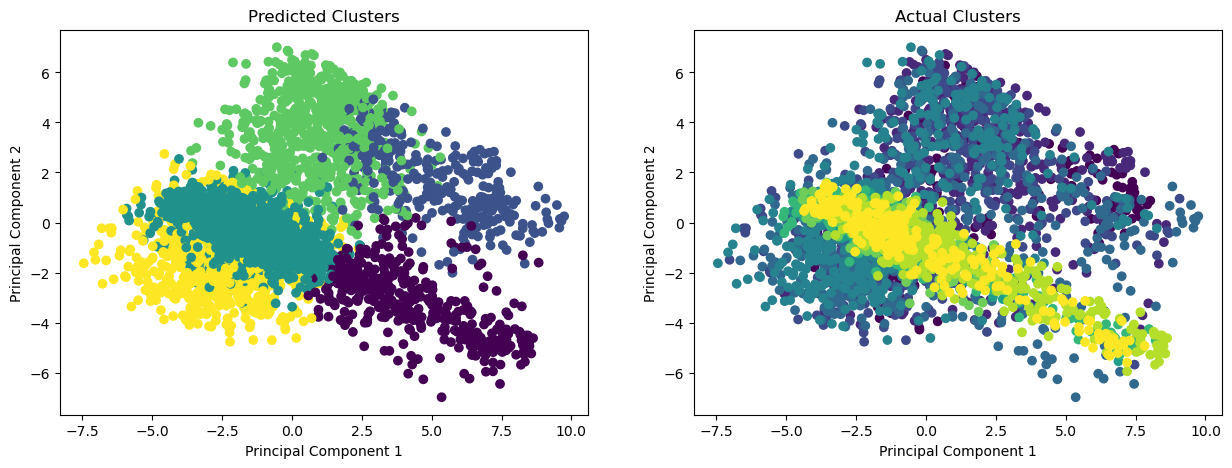

Silhouette Score: 0.05131237672898731
Davies-Bouldin Score: 3.6466811204097502
Adjusted Rand Index: 0.09758358342182351
Normalized Mutual Information: 0.23936948695700322
Fowlkes-Mallows Score: 0.26342350827339556
Homogeneity, Completeness, V-Measure: (0.19724125130330064, 0.30438153067621554, 0.23936948695700327)
Hungarian Algorithm Accuracy: 0.24934036939313983



 Num Clusters  6 :


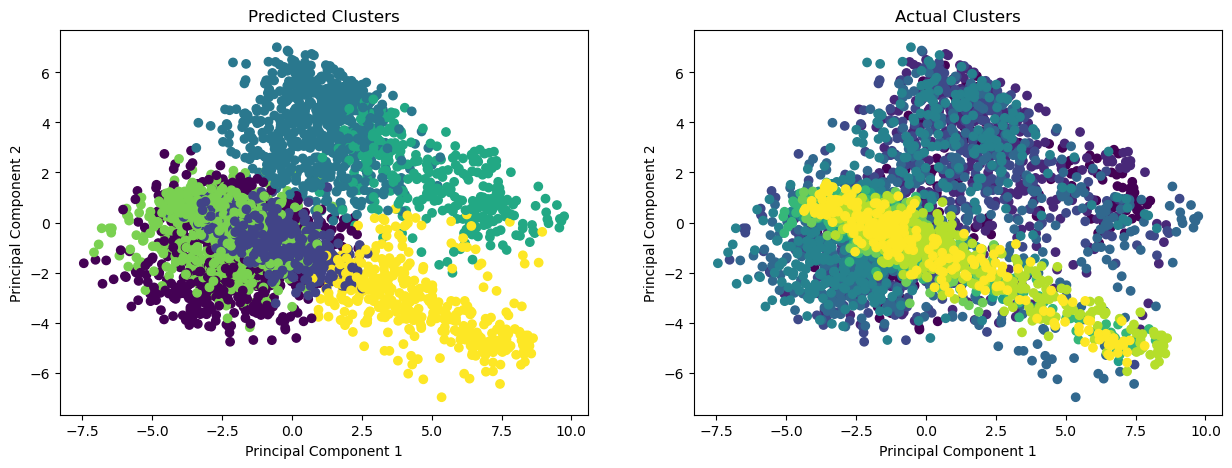

Silhouette Score: 0.048509617425424124
Davies-Bouldin Score: 3.9481605591957205
Adjusted Rand Index: 0.10766111110257578
Normalized Mutual Information: 0.2466909061912113
Fowlkes-Mallows Score: 0.24018038835102976
Homogeneity, Completeness, V-Measure: (0.218372077593045, 0.2834490122804342, 0.2466909061912113)
Hungarian Algorithm Accuracy: 0.2699208443271768



 Num Clusters  7 :


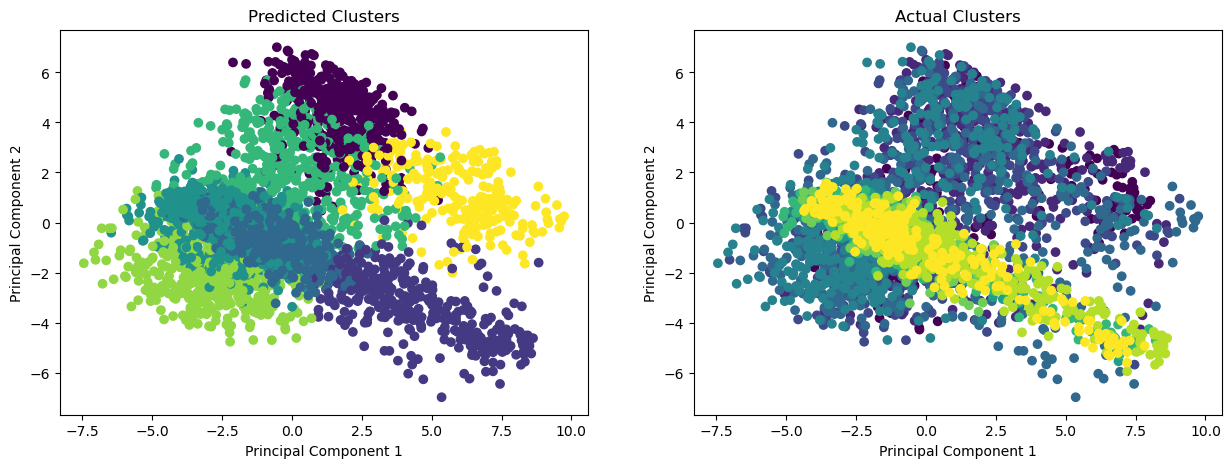

Silhouette Score: 0.04496472939335631
Davies-Bouldin Score: 3.9567988334535316
Adjusted Rand Index: 0.1091080318550351
Normalized Mutual Information: 0.25340864003597285
Fowlkes-Mallows Score: 0.23165286952300423
Homogeneity, Completeness, V-Measure: (0.23242593718788868, 0.2785558064119224, 0.25340864003597285)
Hungarian Algorithm Accuracy: 0.27598944591029023



 Num Clusters  8 :


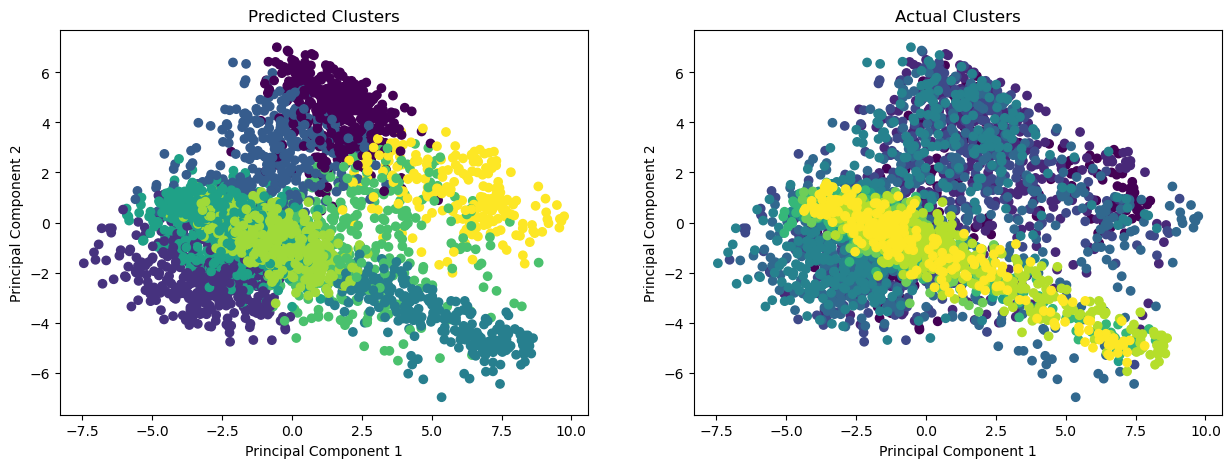

Silhouette Score: 0.04444415593446938
Davies-Bouldin Score: 3.881226188824539
Adjusted Rand Index: 0.10800591924990476
Normalized Mutual Information: 0.25115359663170034
Fowlkes-Mallows Score: 0.22565954038915348
Homogeneity, Completeness, V-Measure: (0.23615210578219908, 0.2681903043199715, 0.2511535966317004)
Hungarian Algorithm Accuracy: 0.28311345646437996



 Num Clusters  9 :


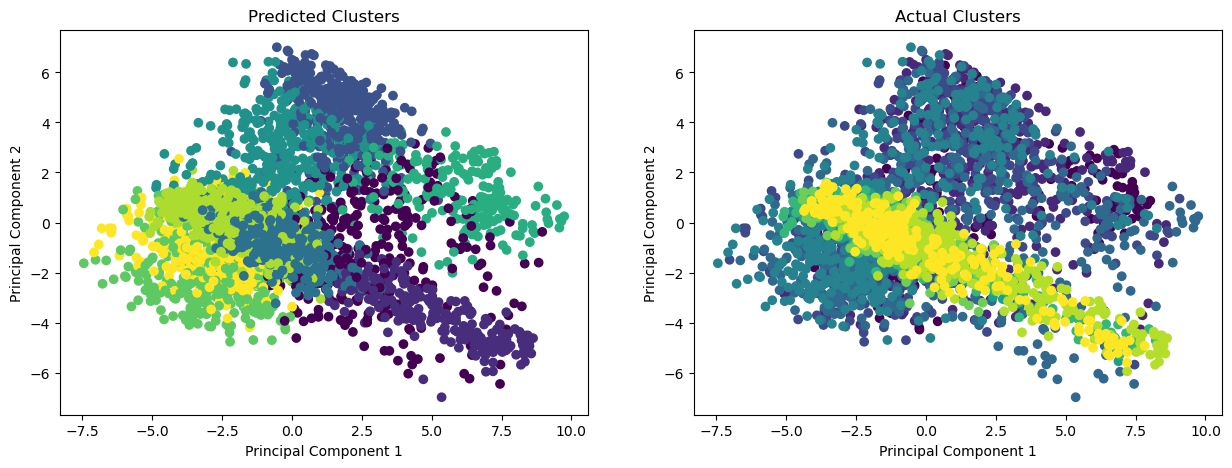

Silhouette Score: 0.042965204090128675
Davies-Bouldin Score: 3.955606111435733
Adjusted Rand Index: 0.13633913767190578
Normalized Mutual Information: 0.29386362169140146
Fowlkes-Mallows Score: 0.23896428161160918
Homogeneity, Completeness, V-Measure: (0.2864613068997974, 0.3016586438733681, 0.2938636216914015)
Hungarian Algorithm Accuracy: 0.2783641160949868



 Num Clusters  10 :


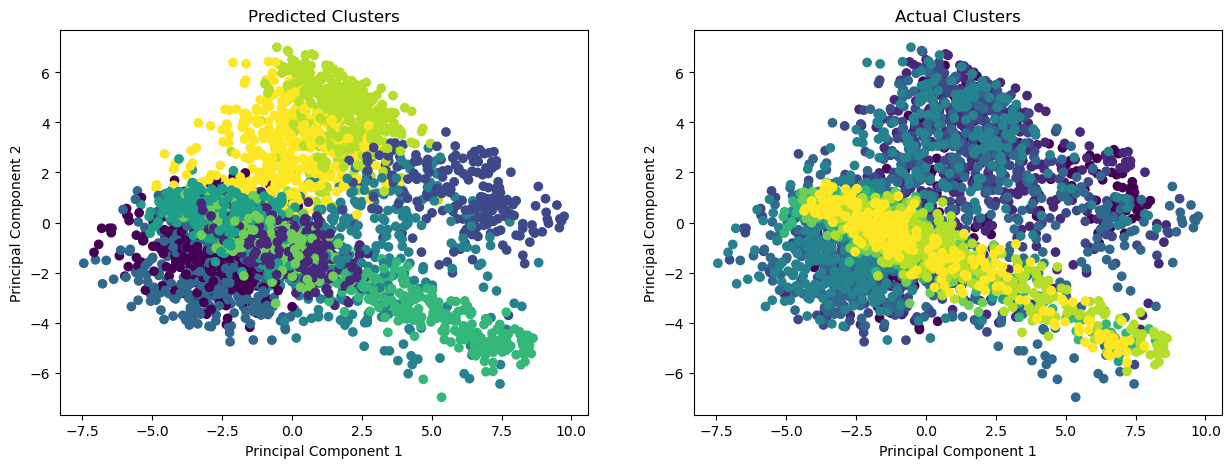

Silhouette Score: 0.04326180039938791
Davies-Bouldin Score: 3.9685698224334565
Adjusted Rand Index: 0.12599438643120192
Normalized Mutual Information: 0.28690468260607244
Fowlkes-Mallows Score: 0.2218228449920484
Homogeneity, Completeness, V-Measure: (0.28810008679104643, 0.28571915753231886, 0.2869046826060725)
Hungarian Algorithm Accuracy: 0.27941952506596307




In [38]:
for i in range(2, num_clusters+1):
    print("\n Num Clusters ", i, ":")
    kmeans = KMeans(n_clusters=i, random_state=42)
    y_pred_kmeans = kmeans.fit_predict(X_train_rus)
    plot_clusters(X_train_rus, y_pred_kmeans, y_train_rus.values)
    display_metrics(X_train_rus, y_train_rus, y_pred_kmeans)
    row_ind_kmeans, col_ind_kmeans = match_clusters(y_train_rus, y_pred_kmeans)
    print(f'Hungarian Algorithm Accuracy: {find_accuracy(y_train_rus, y_pred_kmeans, row_ind_kmeans, col_ind_kmeans)}')
    print('\n')


## Optimal number of clusters

#### Elbow Method

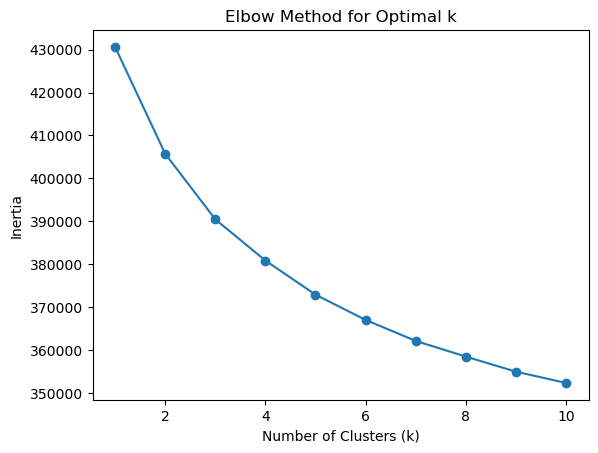

Optimal Number of Clusters: 10


In [39]:
k_range = range(1, 11) 

inertia_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init = 10, max_iter=300, random_state=0)
    kmeans.fit(X_train_rus[:, 0:529])
    inertia_scores.append(kmeans.inertia_)
    

# Plot the elbow curve
plt.plot(k_range, inertia_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Find the optimal number of clusters
optimal_k = inertia_scores.index(min(inertia_scores)) + 1  # Index starts from 0, so add 1
print(f"Optimal Number of Clusters: {optimal_k}")

#### Silhouette Method

The code in this section has been adjusted from the P4 tutorial on canvas

For n_clusters = 2 The average silhouette_score is : 0.06570397282357511
For n_clusters = 3 The average silhouette_score is : 0.058270106669363615
For n_clusters = 4 The average silhouette_score is : 0.051162327887104536
For n_clusters = 5 The average silhouette_score is : 0.05114385150871205
For n_clusters = 6 The average silhouette_score is : 0.048586683458680634
For n_clusters = 7 The average silhouette_score is : 0.044993380342931585
For n_clusters = 8 The average silhouette_score is : 0.04417659366822961
For n_clusters = 9 The average silhouette_score is : 0.042250269396454335
For n_clusters = 10 The average silhouette_score is : 0.043576973952320935


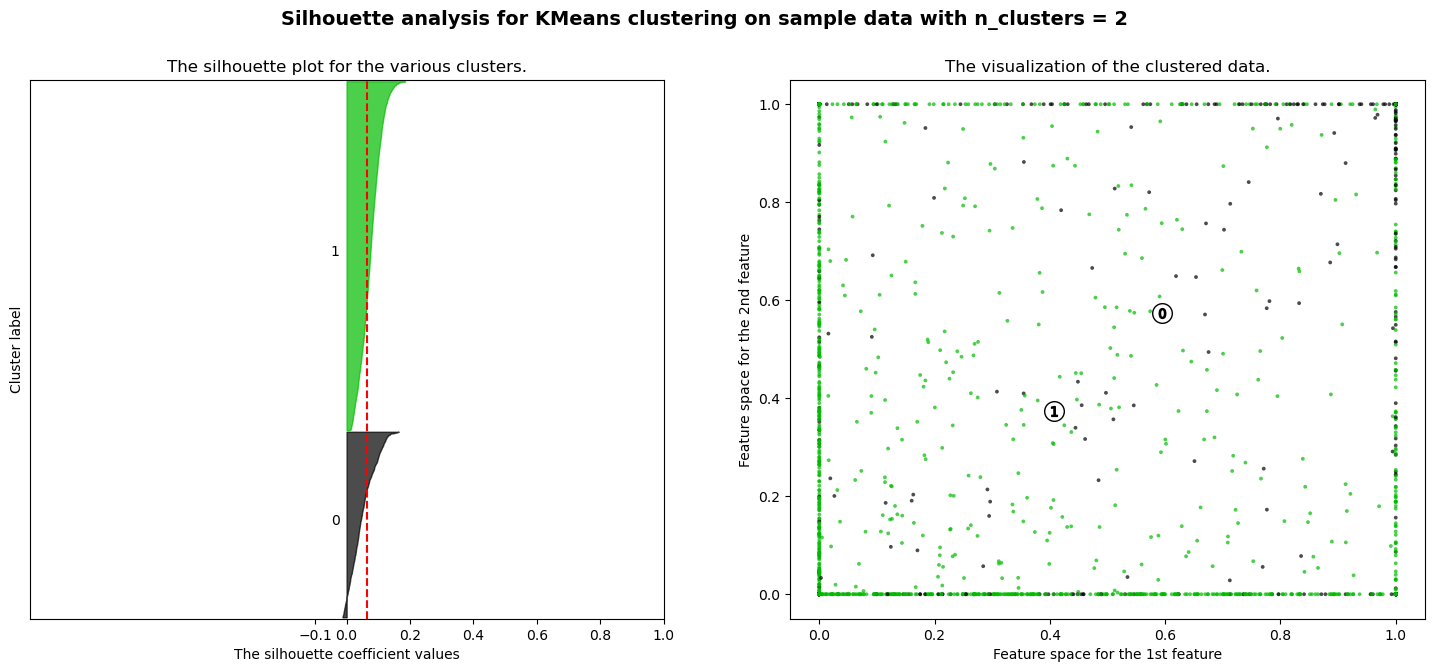

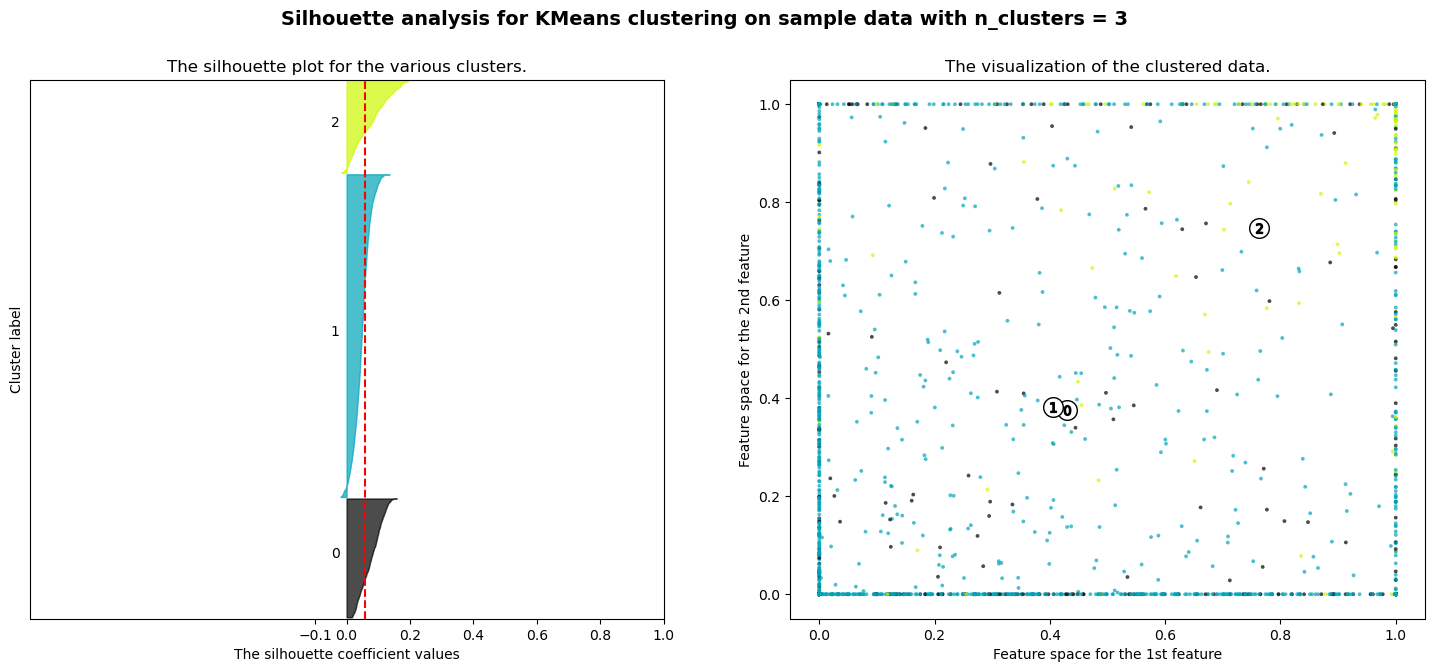

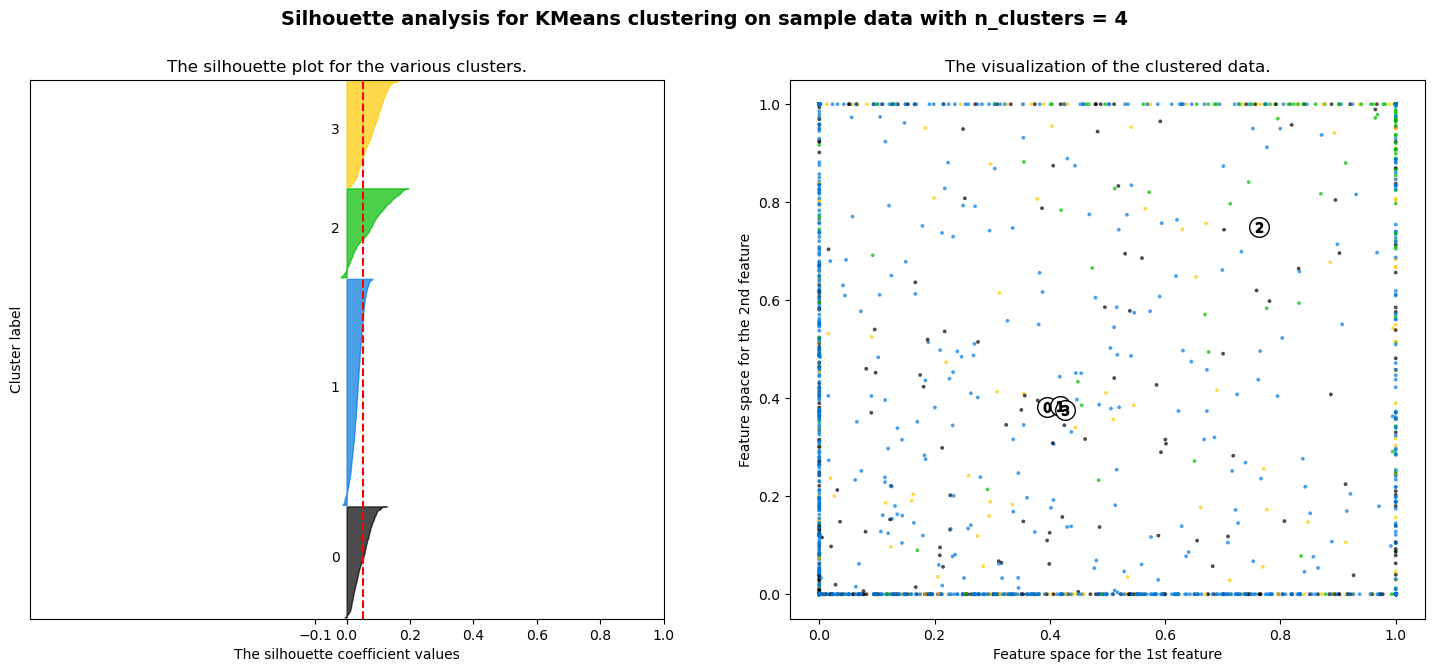

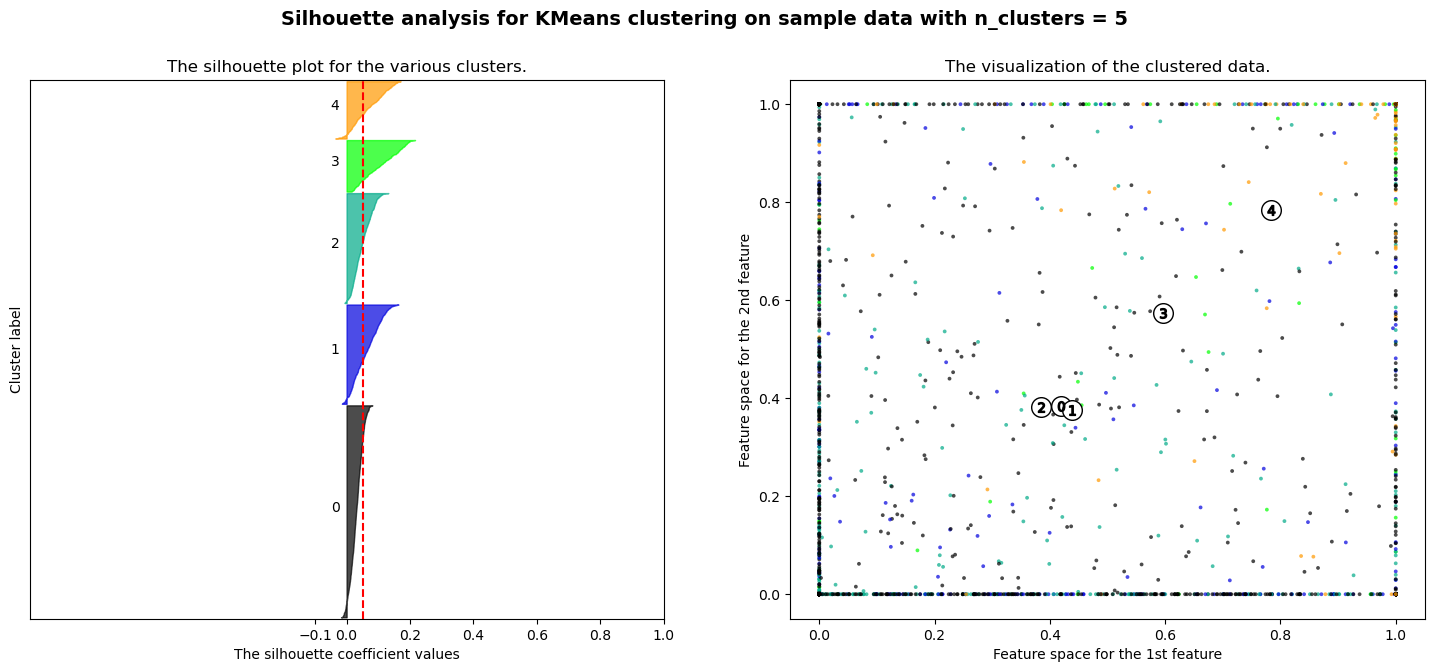

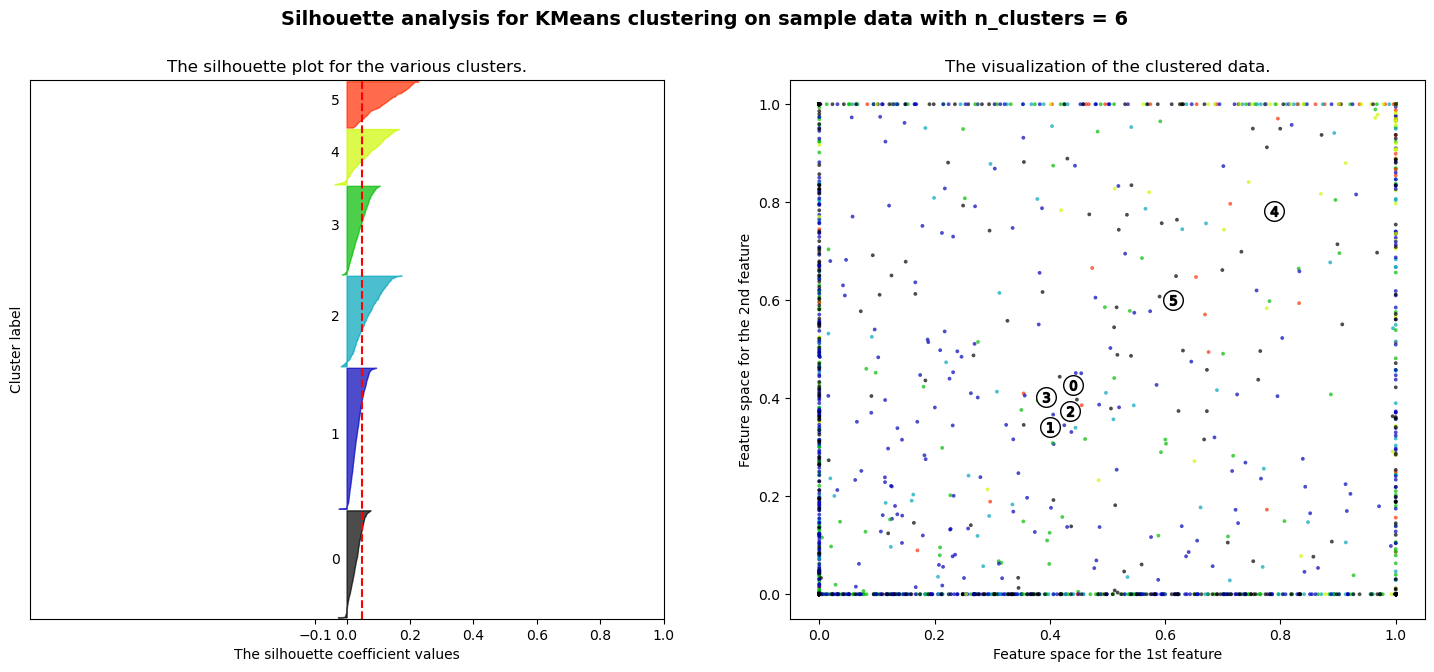

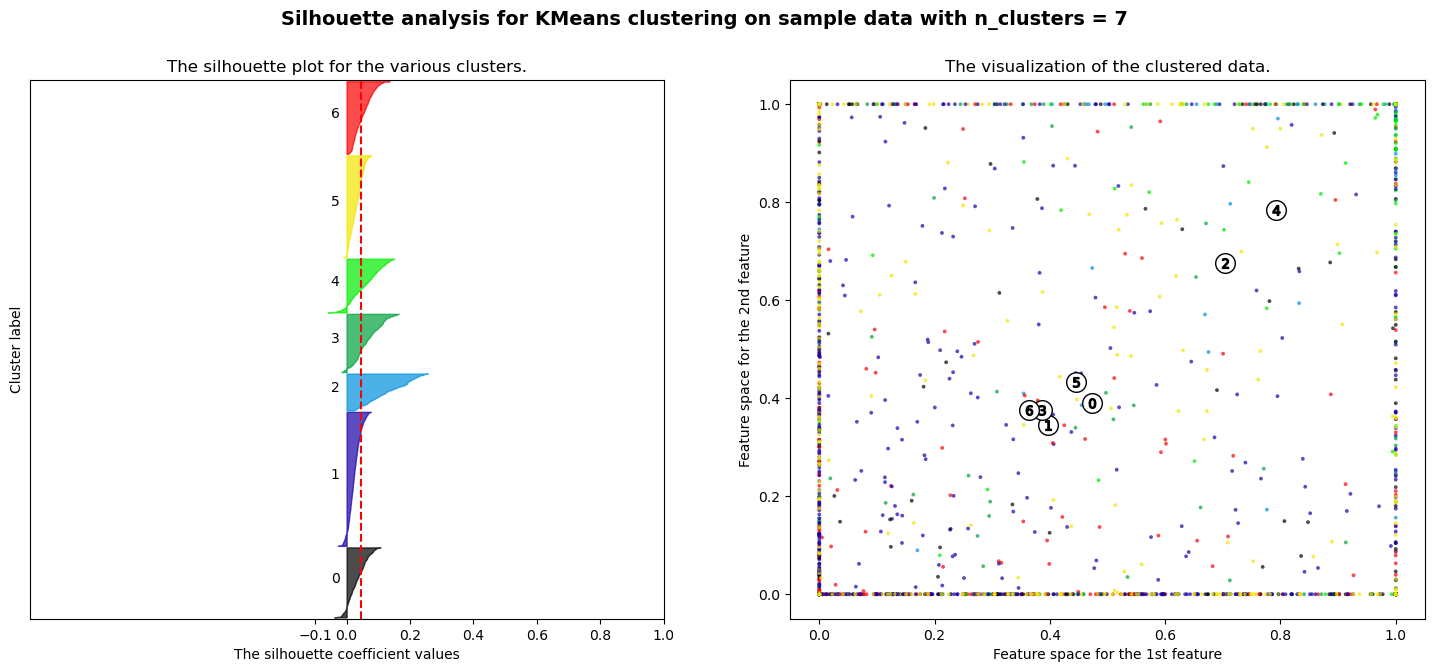

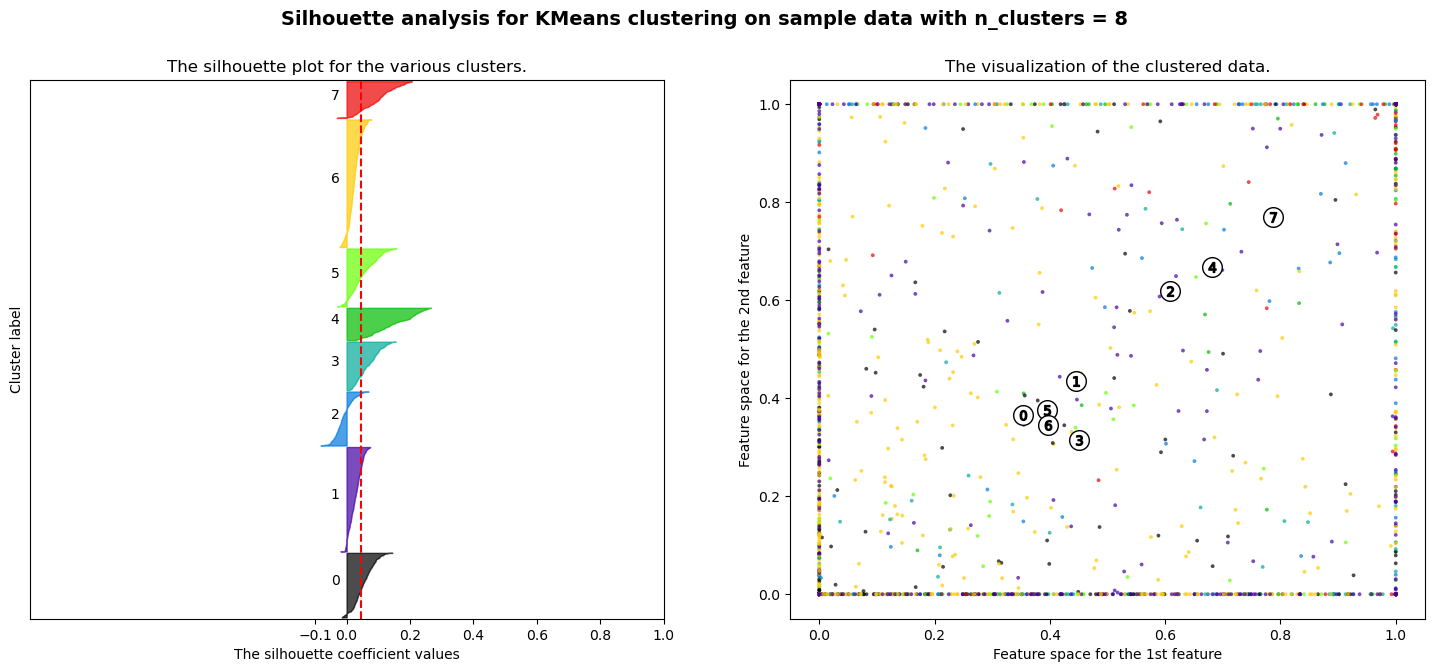

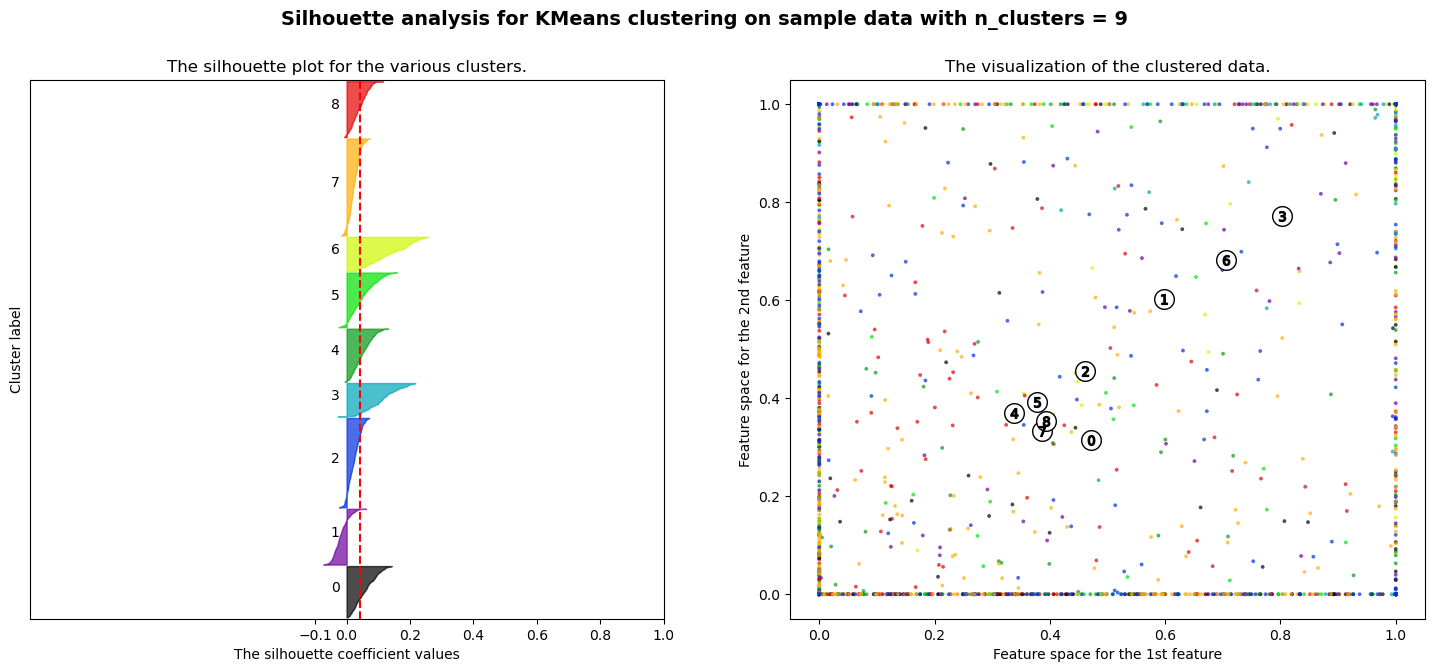

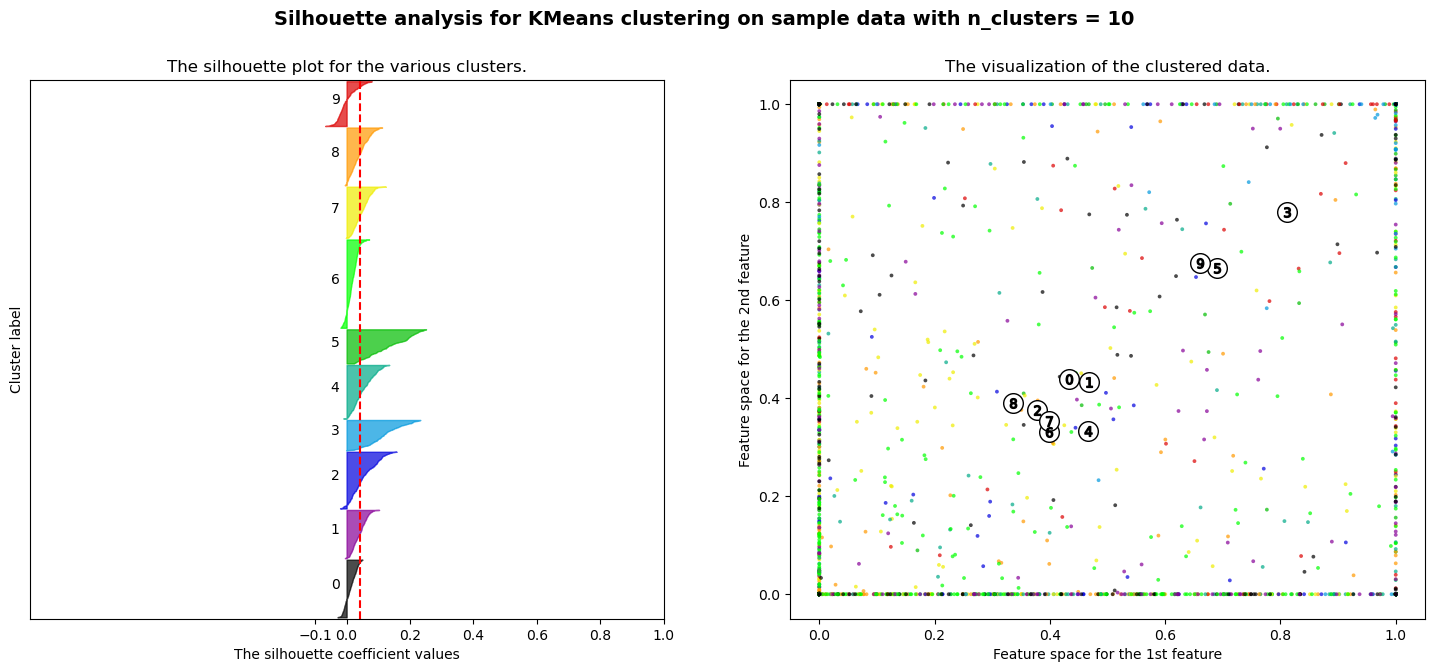

In [40]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_train_rus) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_train_rus)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train_rus, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train_rus, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_train_rus[:, 0], X_train_rus[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## Naive Bayes vs Clustering

##### Naive Bayes is a supervised machine learning algorithm used primarily for classification, that is to predict the class label of instances based on their features assuming conditional independence within the dataset. However, clustering is an unsupervised machine-learning technique used to group similar instances (clusters) together based on their features without having predefined class labels. Clustering works better when there are fewer features. Image data sets always need to be reduced in dimensionality for clustering


## Analysis of Clustering Algorithms


| **Algorithm**    | **Pros**                                                                        | **Cons**                                                                   |
| ------------ | --------------------------------------------------------------------------- | ----------------------------------------------------------------------- |
| **KMeans**       | - Adept for large datasets                                                   | - Requires specifying the number of clusters beforehand                  |
|              | - Suitable for spherical and convex clusters best (inertia)                | - Struggles with higher cluster numbers                                  |
|              |                                                                           | - Assumes equal-sized clusters                                           |
| **DBSCAN**       | - Able to discover clusters of arbitrary and uneven shape                  | - Requires specifying two hyperparameters (eps and min_samples)           |
|              | - Tolerant to noise/outliers                                                | - Sensitive to fluctuation of these parameters                           |
| **Spectral**     | - Able to discover non-convex clusters with complex shapes                 | - High computational cost, especially for large datasets                 |
|              | - Not restricted to equal-sized clusters                                    | - Requires choosing the number of clusters                                |
| **Hierarchical** | - Suitable for dynamic clustering tasks                                     | - High computational cost                                                |
|              | - Provides a clear visual representation of data point groupings           | - Can lead to uneven cluster sizes depending on linkage strategies       |
| **BIRCH**        | - Suitable for larger datasets                                              | - Lower effectiveness on categorical data types                           |
|              | - Good at outlier detection and removal                                     | - Ineffective performance on irregularly shaped clusters                  |
|              | - Greater scalability                                                      |                                                                        |
| **OPTICS**       | - Robust to noise and outliers                                              | - Complex reachability plots                                              |
|              | - Suitable for uneven cluster sizes and varying cluster densities           | - Requires tuning of hyperparameters                                      |
